In [1]:
from functions_for_all_nutrients import *
from iron_hemoglobin_functions import *

In [2]:
zinc = pd.read_pickle('results_raw/zinc.pkl')
zinc['nutrient'] = 'zinc'
vitamin_a = pd.read_pickle('results_raw/vitamin_a.pkl')
vitamin_a['nutrient'] = 'vitamin a'
iron_u5 = pd.read_pickle('results_raw/iron_u5.pkl')
iron_u5['nutrient'] = 'iron'
iron_u5 = iron_u5.loc[iron_u5.year==2025]
iron_wra = pd.read_pickle('results_raw/iron_wra.pkl')
iron_wra['nutrient'] = 'iron'
iron = (iron_wra.set_index([c for c in iron_wra.columns if 'draw' not in c]) 
        + iron_u5.set_index([c for c in iron_wra.columns if 'draw' not in c])).reset_index()

results = pd.concat([zinc, vitamin_a, iron], ignore_index=True, sort=True)
results['nutrient'] = results.nutrient.str.replace('vitamin a','vitamin A')
results['nutrient_name'] = results.nutrient.str.replace('_',' ').str.capitalize().str.replace('Vitamin a', 'Vitamin A')
l = get_ids('location')[['location_name','location_id']]
results = results.merge(l, on='location_id')
results['label'] = results.nutrient_name + ' in ' + results.vehicle
results = results.loc[results.year==2025]
results.head()

coverage_level    draw_0    draw_1   draw_10  draw_100  draw_101  \
12             0.2  0.125649  0.338091  0.488604  0.400990  0.327796   
13             0.5  0.314121  0.845226  1.221511  1.002474  0.819490   
14             0.8  0.502594  1.352362  1.954417  1.603959  1.311184   
27             0.2  0.634325  0.103519  0.634680  0.869303  0.143618   
28             0.5  1.585813  0.258798  1.586701  2.173258  0.359044   

    draw_102  draw_103  draw_104  draw_105  ...  draw_998  draw_999  \
12  0.349153  0.529618  0.401699  0.431137  ...  0.449194  0.417276   
13  0.872881  1.324046  1.004248  1.077842  ...  1.122984  1.043190   
14  1.396610  2.118473  1.606797  1.724547  ...  1.796774  1.669104   
27  0.237264  0.410100  1.538719  1.691311  ...  0.911400  1.265634   
28  0.593161  1.025249  3.846796  4.228277  ...  2.278499  3.164085   

    location_id         measure  nutrient      vehicle    year  nutrient_name  \
12           15             pif      zinc  wheat flour  2025.0           Zinc   
13           15             pif      zinc  wheat flour  2025.0           Zinc   
14           15             pif      zinc  wheat flour  2025.0           Zinc   
27           15  counts_averted      zinc  wheat flour  2025.0           Zinc   
28           15  counts_averted      zinc  wheat flour  2025.0           Zinc   

    location_name                label  
12        Myanmar  Zinc in wheat flour  
13        Myanmar  Zinc in wheat flour  
14        Myanmar  Zinc in wheat flour  
27        Myanmar  Zinc in wheat flour  
28        Myanmar  Zinc in wheat flour  

[5 rows x 1009 columns]

In [3]:
def make_dot_plots_by_nutrient_vehicle_pair(data, nutrient, measure, coverage_levels):
    """This function takes a dataframe,
    nutrient (as a string),
    and measure (as a string, either: 'rates', 'counts', or 'pifs').
    """

    f, ax = plt.subplots(figsize=(7, 4), dpi=120)
    colors = ['tab:red', 'tab:orange', 'tab:green']

    location_spacer = 0.15
    coverage_spacer = 0.025
    df = (data.drop(columns='measure', errors='ignore')
          .apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).reset_index())

    order = df.reset_index()
    order = list(
        order.loc[order.coverage_level == 0.8].loc[order.year == 2025].sort_values(by='mean').location_id.values)
    nums = list(range(0, len(order)))
    orders = pd.DataFrame()
    orders['location_id'] = order
    orders['order'] = nums
    df = df.merge(orders, on='location_id').sort_values(by='order', ascending=False)

    for n in list(range(0, len(coverage_levels))):
        rate = (df.loc[df.year == 2025]
            .loc[df.coverage_level == coverage_levels[n]])
        for i in list(range(0, len(rate))):
            plt.plot([location_spacer * i + coverage_spacer * n, location_spacer * i + coverage_spacer * n],
                     [rate['2.5%'].values[i], rate['97.5%'].values[i]], c='black')
            plt.scatter([location_spacer * i + coverage_spacer * n], rate['2.5%'].values[i], s=50, marker='_',
                        c='black')
            plt.scatter([location_spacer * i + coverage_spacer * n], rate['97.5%'].values[i], s=50, marker='_',
                        c='black')

        x_vals = []
        for x in list(range(0, len(rate))):
            x_vals.append(location_spacer * x + coverage_spacer * n)
        plt.scatter(x_vals, rate['mean'], s=50,
                    label=f'{int(coverage_levels[n] * 100)} percent coverage', color=colors[n])

    plt.hlines(0, 0 - coverage_spacer * 2,
               location_spacer * (len(rate)) - coverage_spacer * 2,
               linestyle='dashed', color='grey', alpha=0.5)

    plt.plot()

    if measure == 'rates_averted':
        plt.title(f'DALYs averted per 100,000 person-years due to\n{nutrient} fortication in {vehicle}')
        plt.ylabel('DALYs Averted per 100,000')
    elif measure == 'counts_averted':
        plt.title(f'DALYs averted due to\n{nutrient} fortication in {vehicle}')
        plt.ylabel('DALYs')
    elif measure == 'pif':
        plt.title(f'Population impact fraction of {nutrient} fortication in {vehicle}\non DALYs as a proportion of {nutrient} deficiency attributable DALYs')
        plt.ylabel('Population Impact Fraction (Percent)')

    plt.legend(bbox_to_anchor=[1.5, 1])

    x_ticks = []
    for x in list(range(0, len(rate))):
        x_ticks.append(location_spacer * x + coverage_spacer)
    ax.set_xticks(x_ticks)
    plt.xticks(rotation=90)
    ax.set_xticklabels(rate.location_name.values)

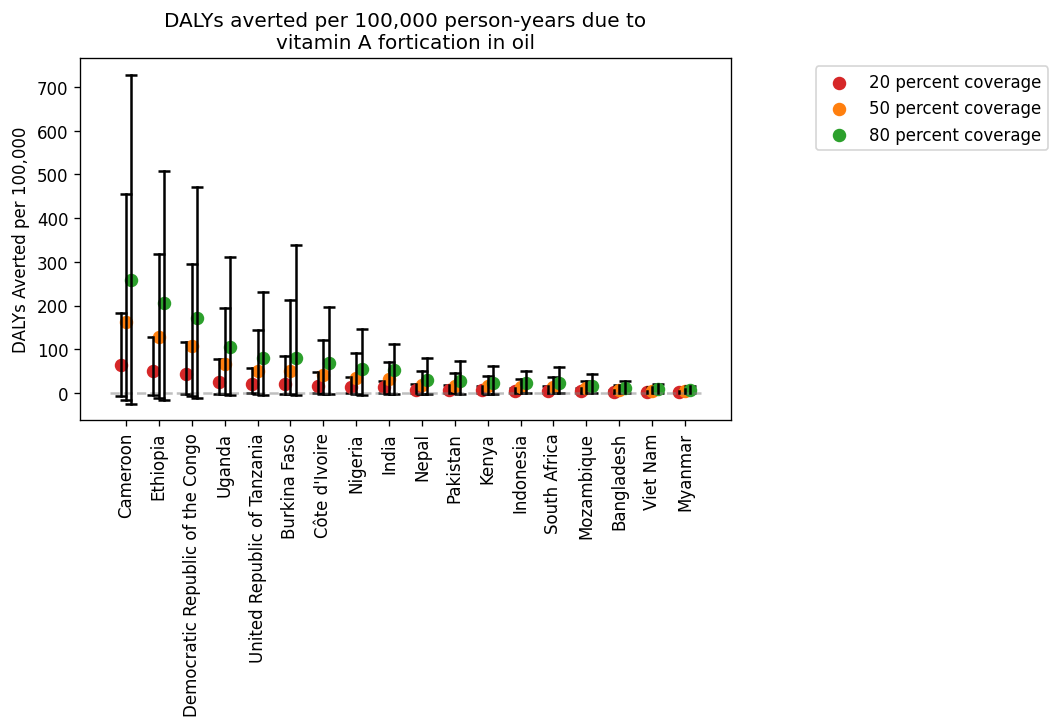

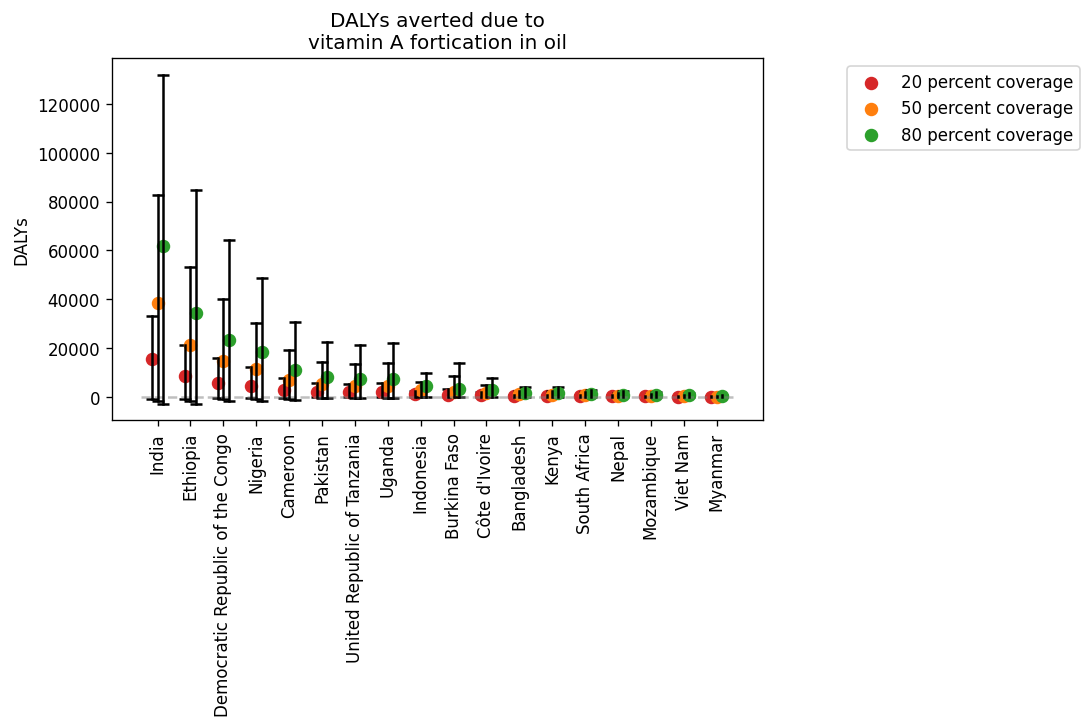

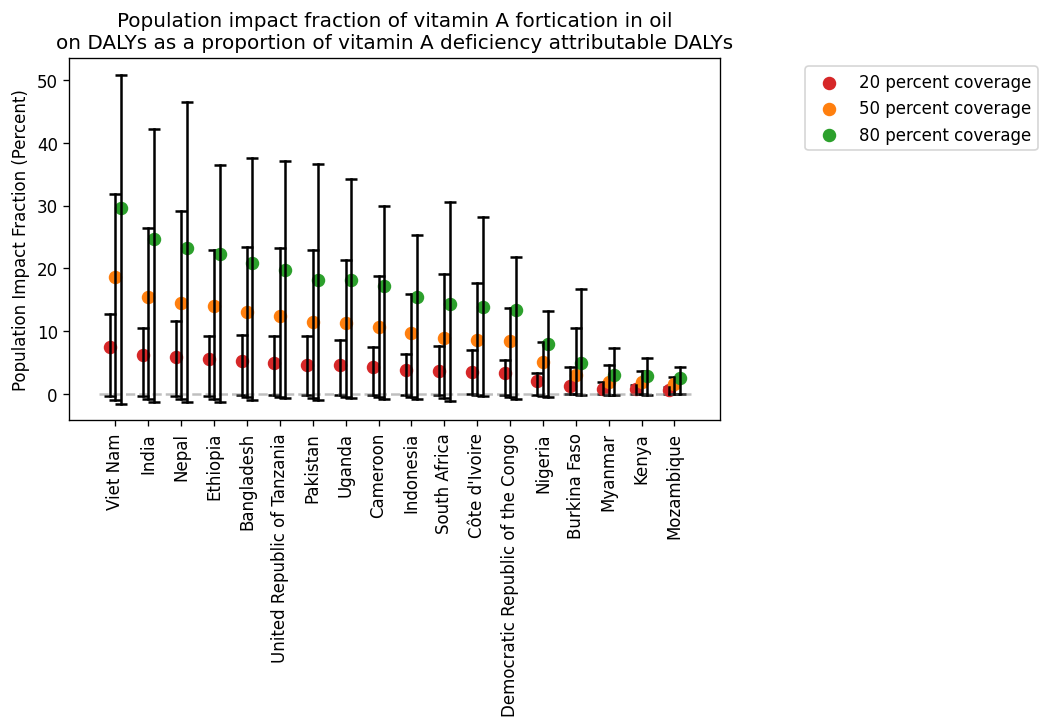

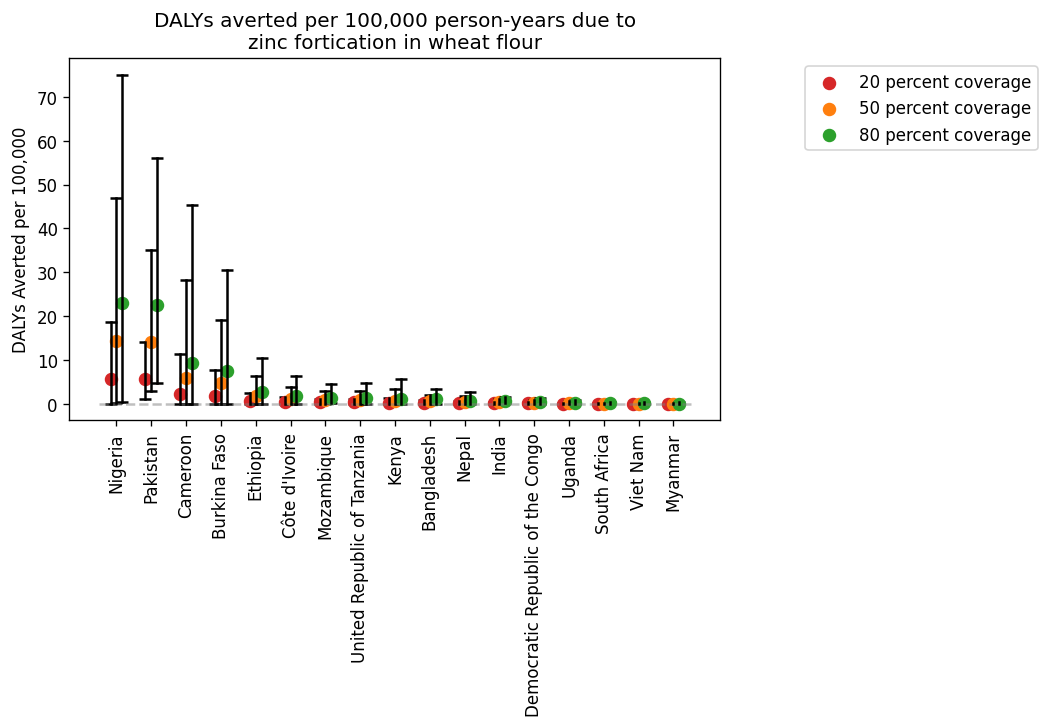

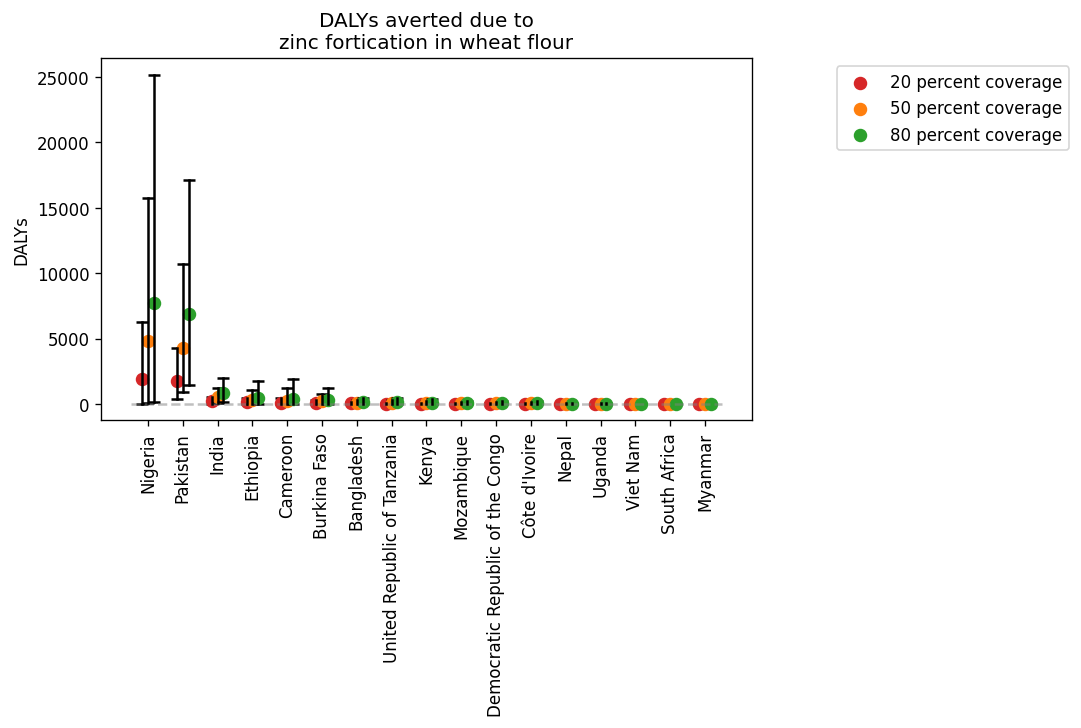

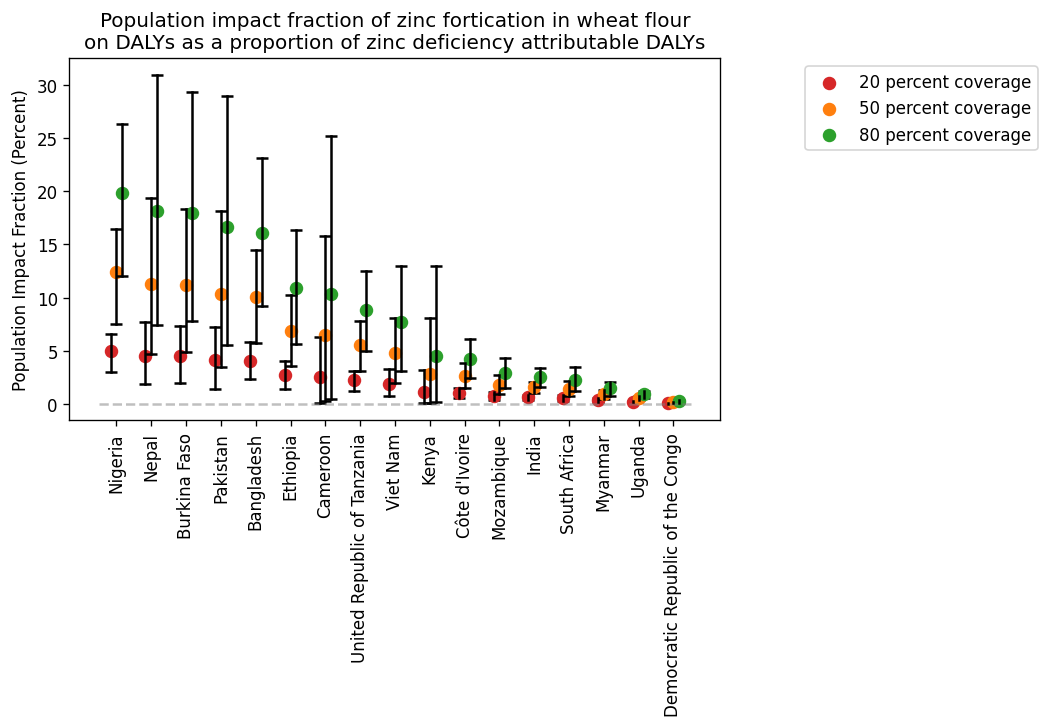

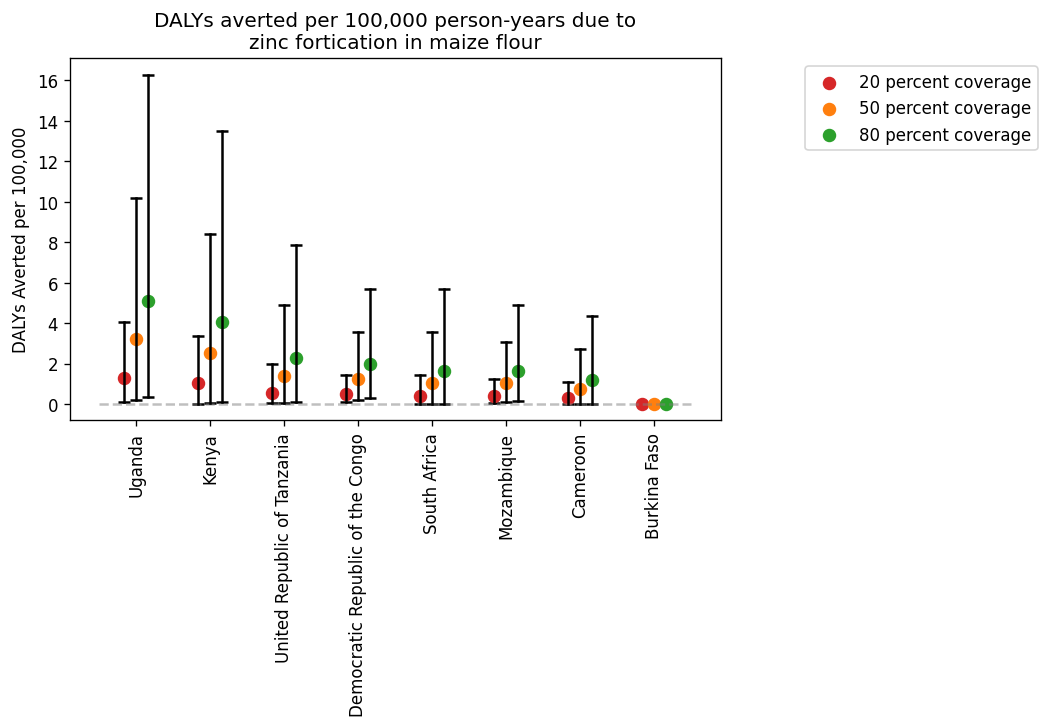

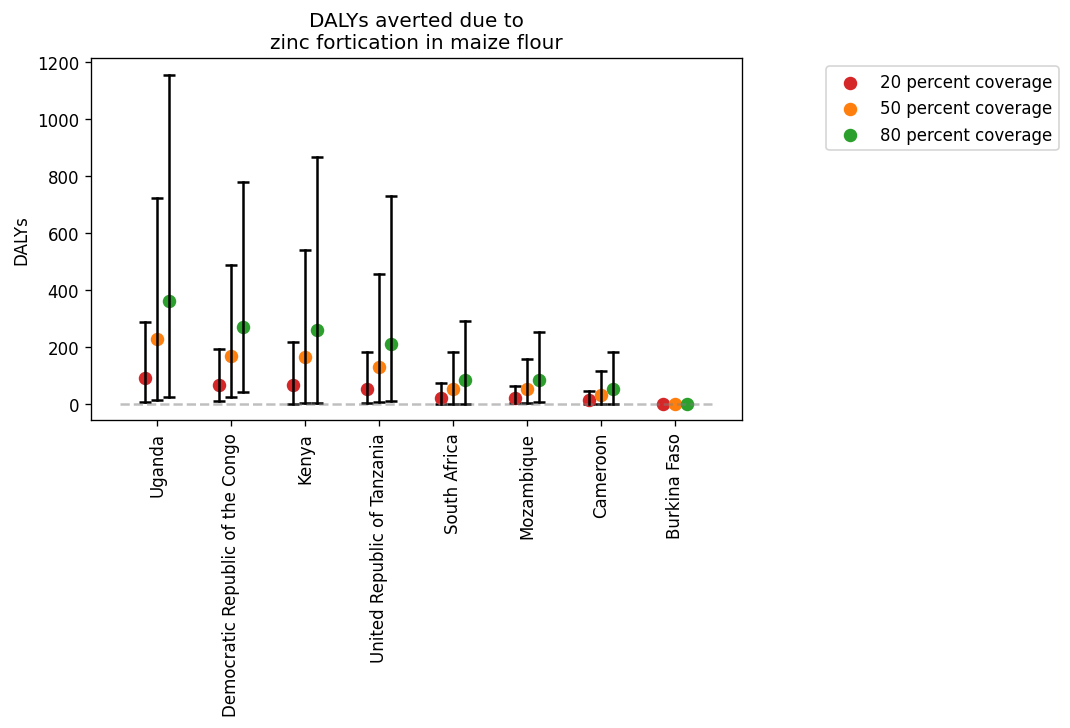

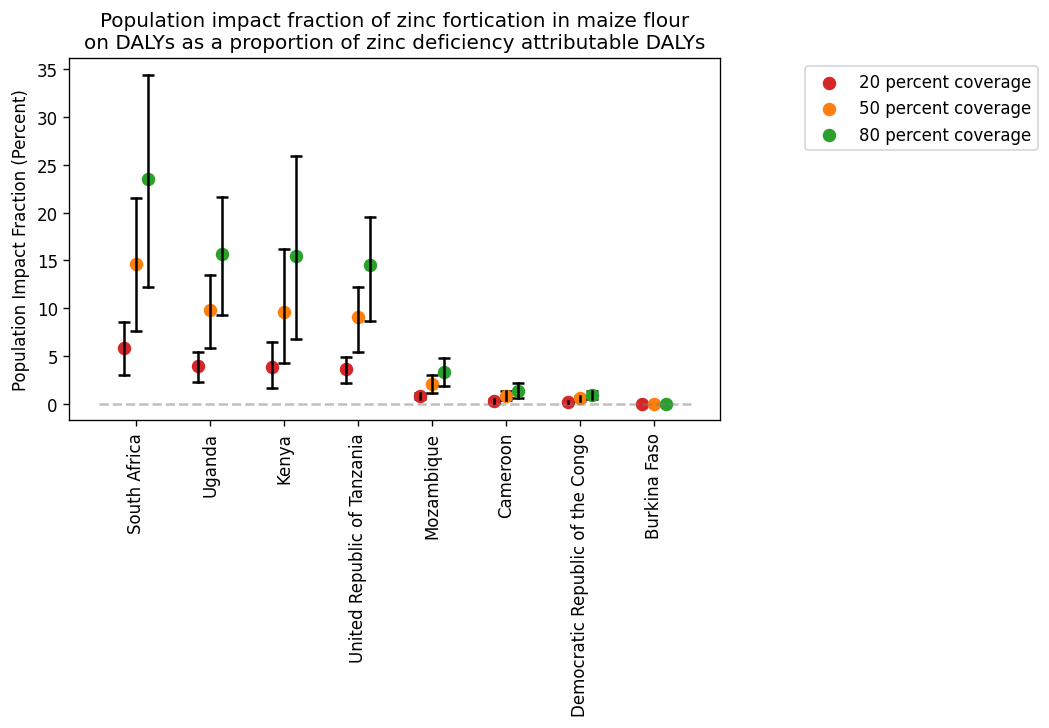

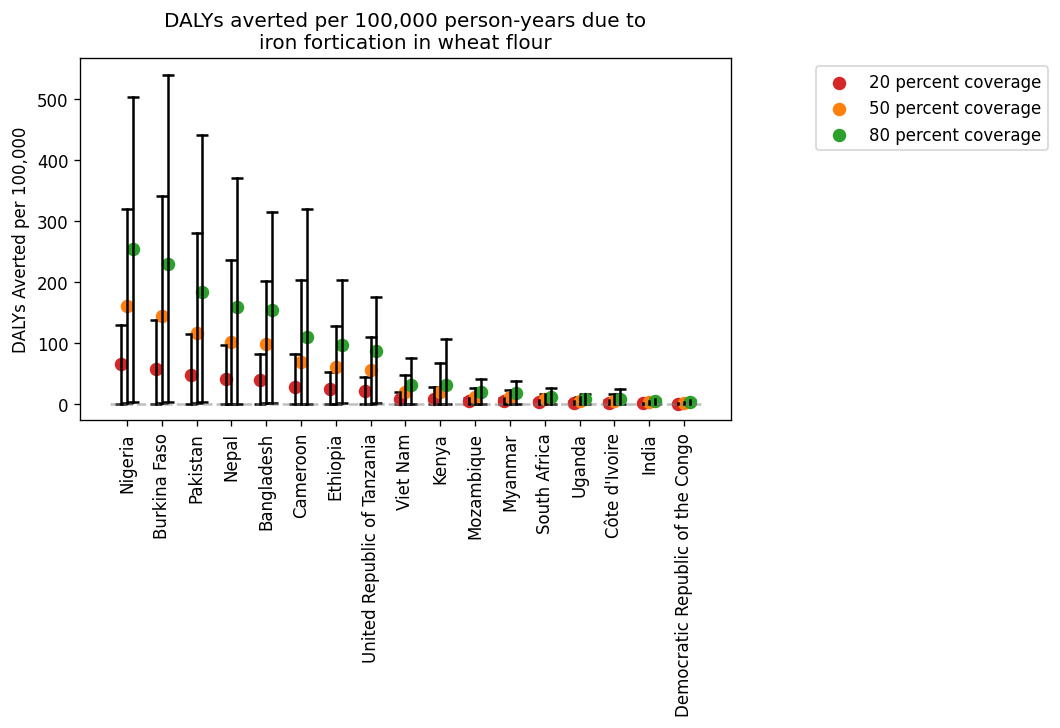

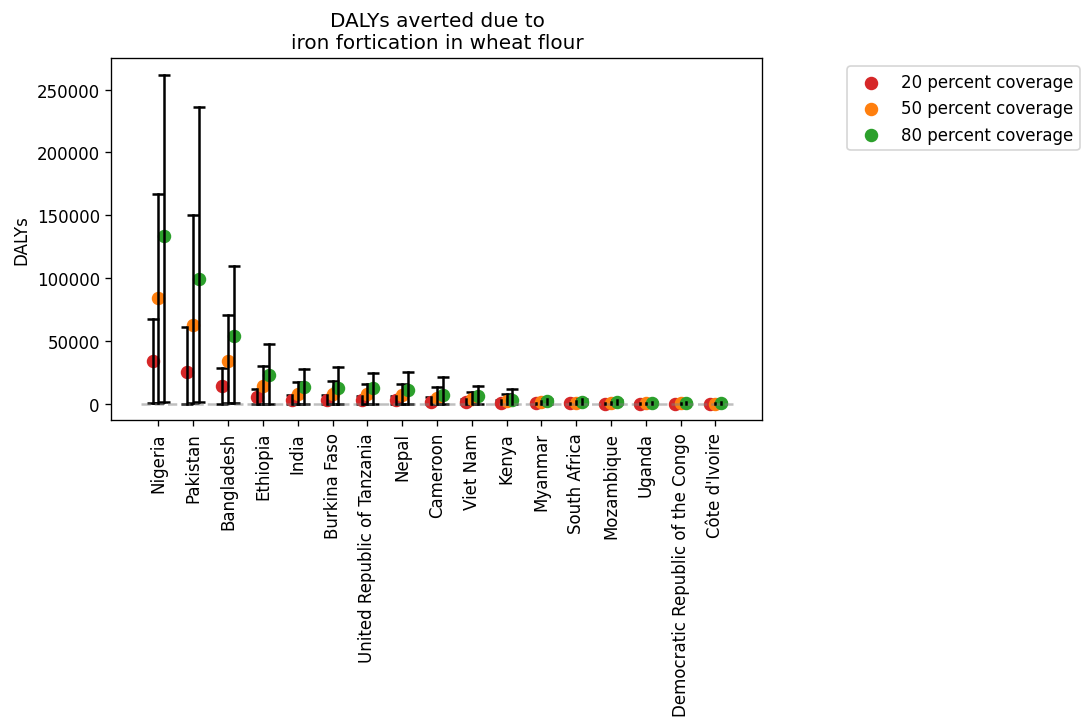

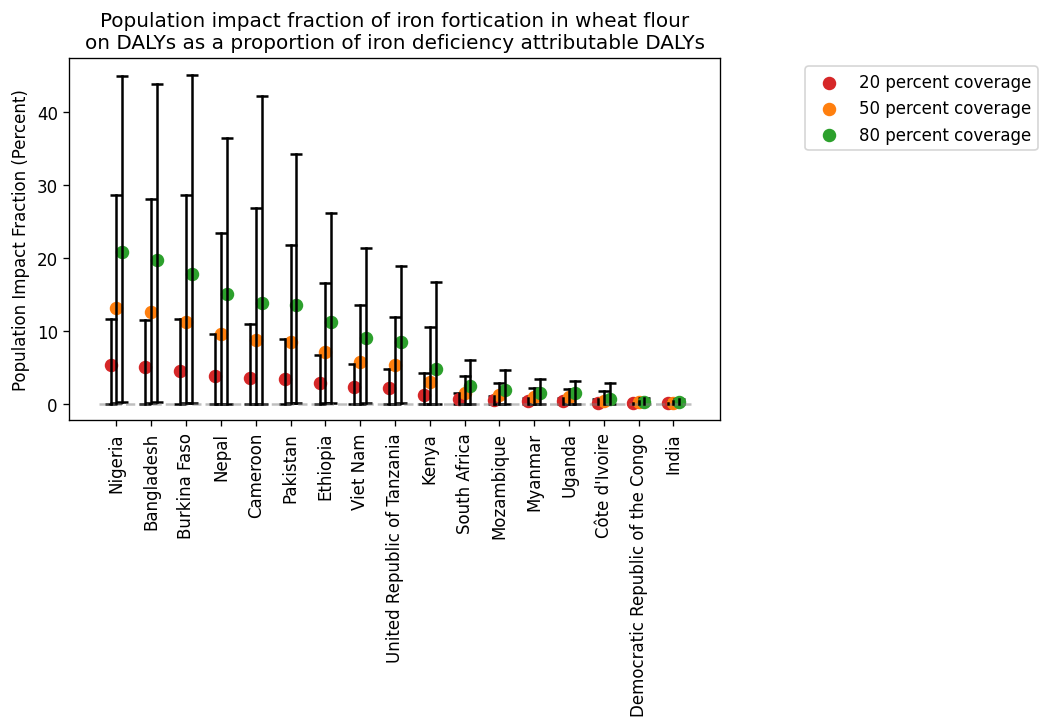

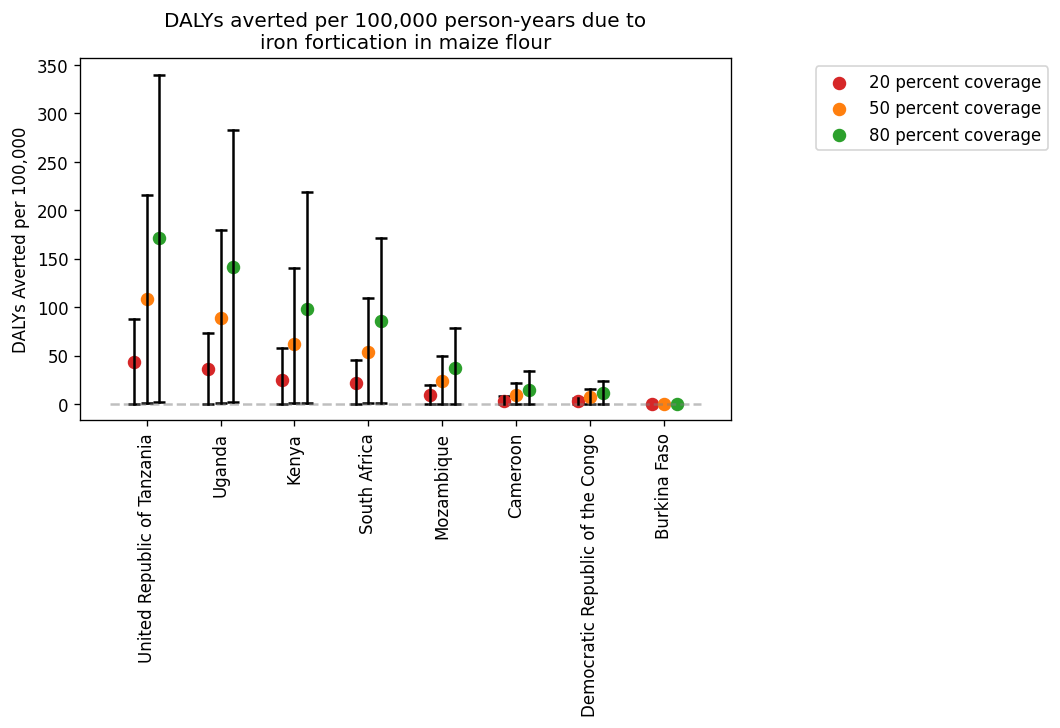

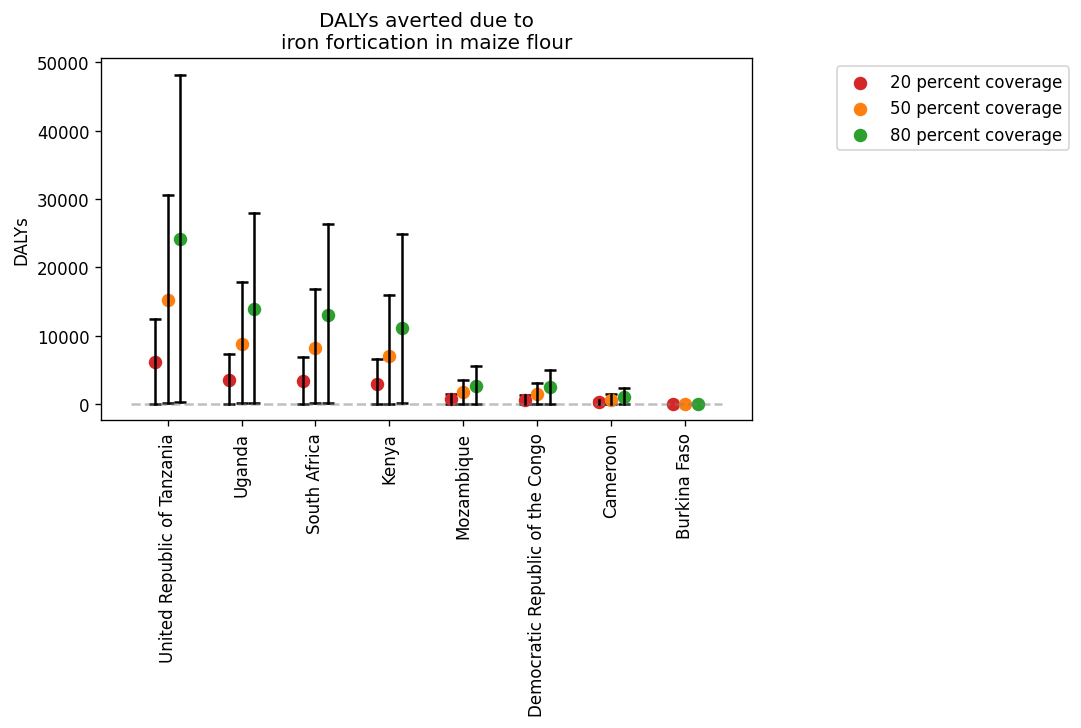

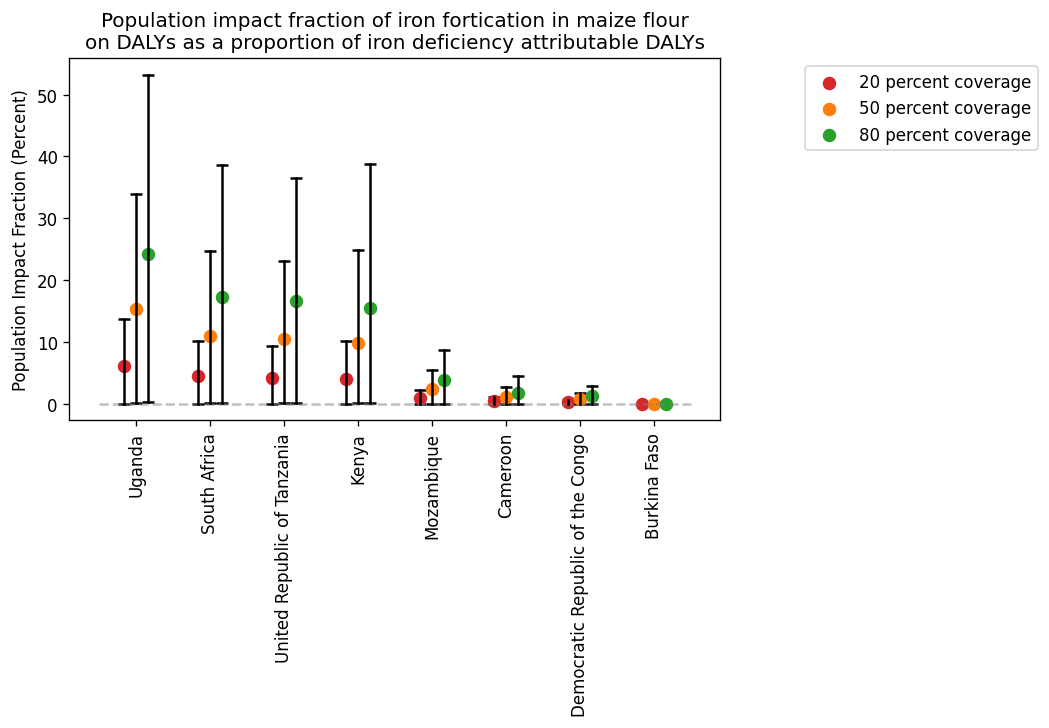

In [4]:
nutrients = ['vitamin A','zinc','iron']
measures = ['rates_averted','counts_averted','pif']
coverage_levels = [0.2,0.5,0.8]

with PdfPages('results_plots/impact_by_nutrient_vehicle_pair.pdf') as pdf:
    for nutrient in nutrients:
        if nutrient == 'vitamin A':
            vehicles = ['oil']
        else:
            vehicles = ['wheat flour', 'maize flour']
        for vehicle in vehicles:
            for measure in measures:
                plot = (results.loc[results.nutrient == nutrient]
                        .loc[results.vehicle == vehicle]
                        .loc[results.measure == measure]
                        .set_index([c for c in results.columns if 'draw' not in c]))
                make_dot_plots_by_nutrient_vehicle_pair(plot,
                              nutrient,
                              measure,
                              coverage_levels)
                pdf.savefig(bbox_inches='tight')

In [5]:
coverage_levels = [0.2,0.5,0.8]

def make_location_specific_plots(data, location_id, measure, coverage_levels):
    data_loc = (data
                .loc[data.location_id==location_id]
                .loc[data.year==2025]
                .loc[data.measure == measure]
                .sort_values(by=['nutrient','vehicle']))
    
    f, ax = plt.subplots(figsize=(7, 4), dpi=120)
    colors = ['tab:red', 'tab:orange', 'tab:green']
    nutrient_spacer = 0.15
    coverage_spacer = 0.025
    data_loc = (data_loc.set_index([c for c in data_loc.columns if 'draw' not in c])
                .apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).reset_index())
    
    for n in list(range(0, len(coverage_levels))):
        df = (data_loc.loc[data_loc.coverage_level == coverage_levels[n]])
        for i in list(range(0, len(df))):
            plt.plot([nutrient_spacer * i + coverage_spacer * n, nutrient_spacer * i + coverage_spacer * n],
                     [df['2.5%'].values[i], df['97.5%'].values[i]], c='black')
            plt.scatter([nutrient_spacer * i + coverage_spacer * n], df['2.5%'].values[i], s=50, marker='_',
                        c='black')
            plt.scatter([nutrient_spacer * i + coverage_spacer * n], df['97.5%'].values[i], s=50, marker='_',
                        c='black')
            
        x_vals = []
        for x in list(range(0, len(df))):
            x_vals.append(nutrient_spacer * x + coverage_spacer * n)
        plt.scatter(x_vals, df['mean'], s=50,
                    label=f'{int(coverage_levels[n] * 100)} percent coverage', color=colors[n])

    plt.hlines(0, 0 - coverage_spacer * 2,
               nutrient_spacer * (len(df)) - coverage_spacer * 2,
               linestyle='dashed', color='grey', alpha=0.5)
    
    plt.plot()
    
    l_name = data_loc.location_name.values[0]

    if measure == 'rates_averted':
        plt.title(f'{l_name}\nDALYs Averted per 100,000 Person-Years by Nutrient')
        plt.ylabel('DALYs Averted per 100,000')
    elif measure == 'counts_averted':
        plt.title(f'{l_name}\nDALYs Averted by Nutrient')
        plt.ylabel('DALYs')
    elif measure == 'pif':
        plt.title(f'{l_name}\nPopulation Impact Fractions by Nutrient\nDALYs Averted as a Fraction of DALYs Attributable to Respective Nutrient Deficiencies')
        plt.ylabel('Population Impact Fraction (Percent)')

    plt.legend(bbox_to_anchor=[1.5, 1])
    
    x_ticks = []
    for x in list(range(0, len(df))):
        x_ticks.append(nutrient_spacer * x + coverage_spacer)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(df.reset_index().label.values)
    plt.xticks(rotation=90)

/ihme/code/central_comp/miniconda_svc-ccomp/envs/v107/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


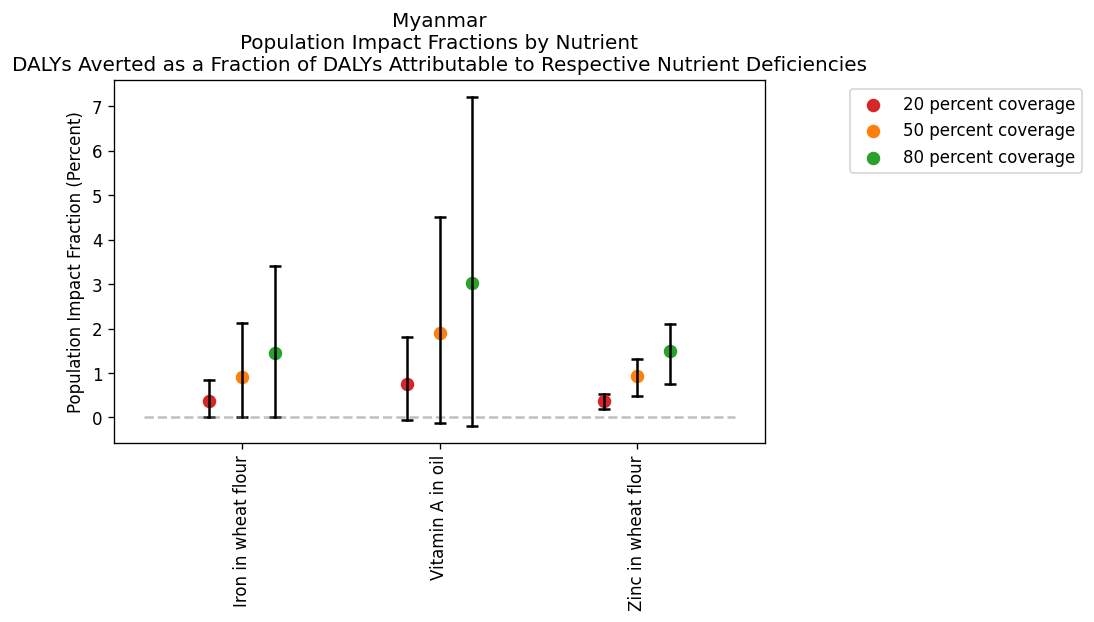

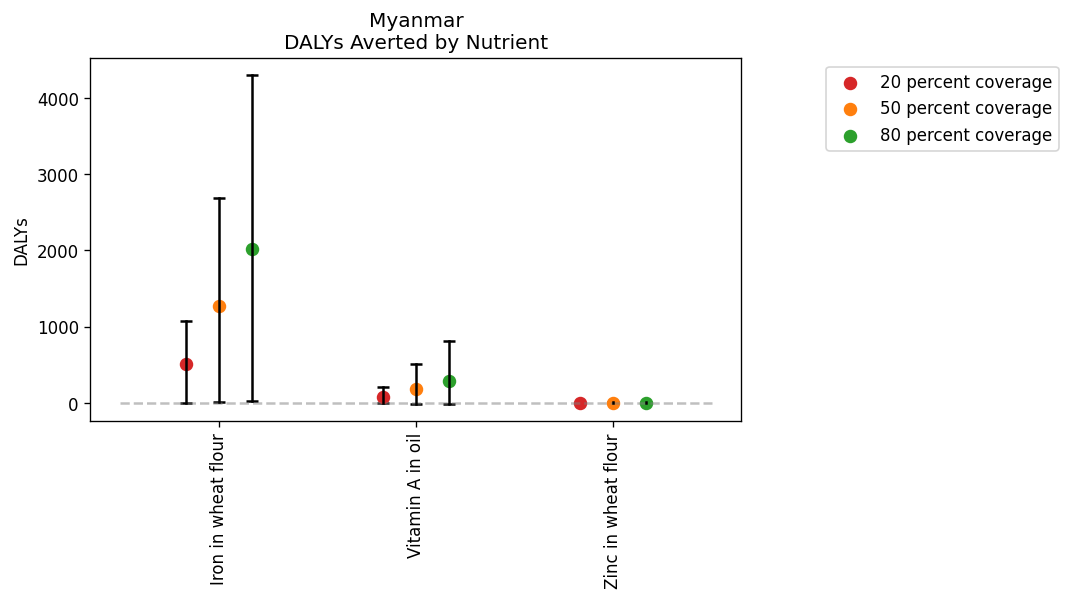

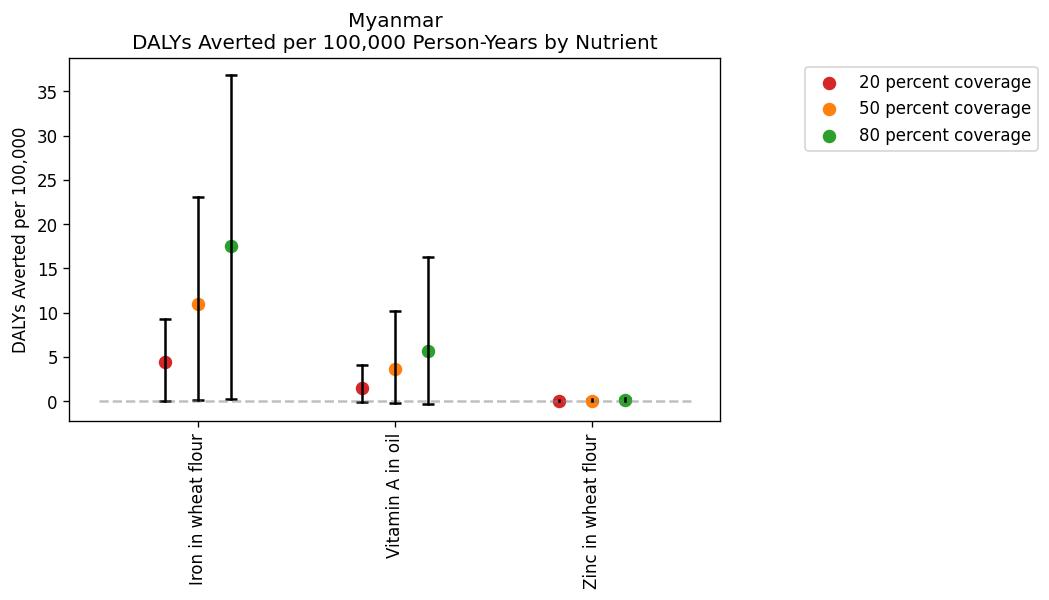

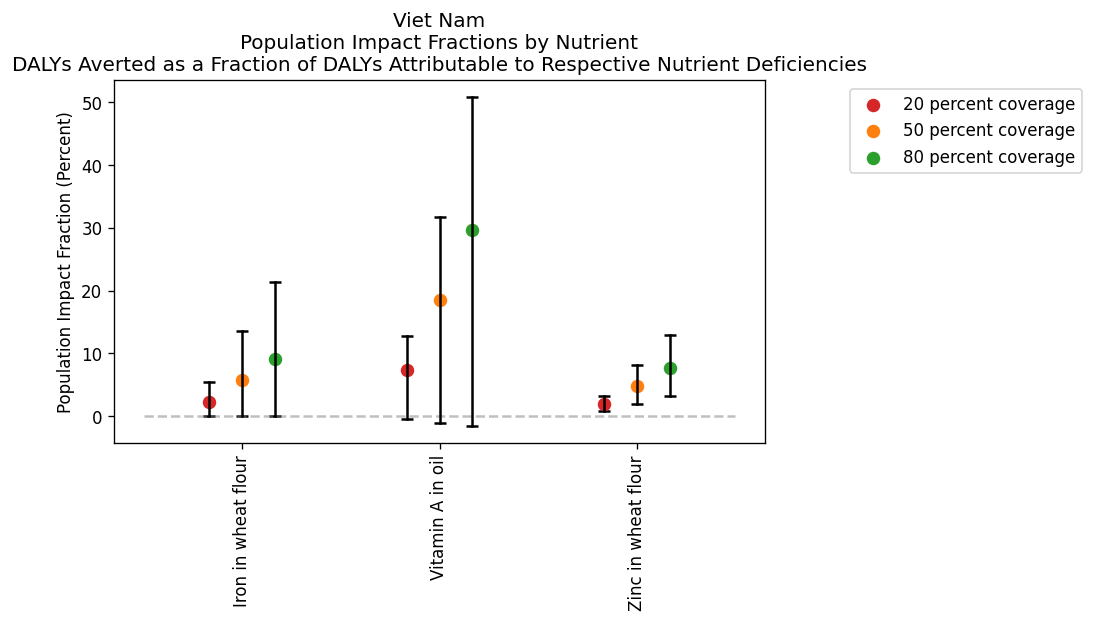

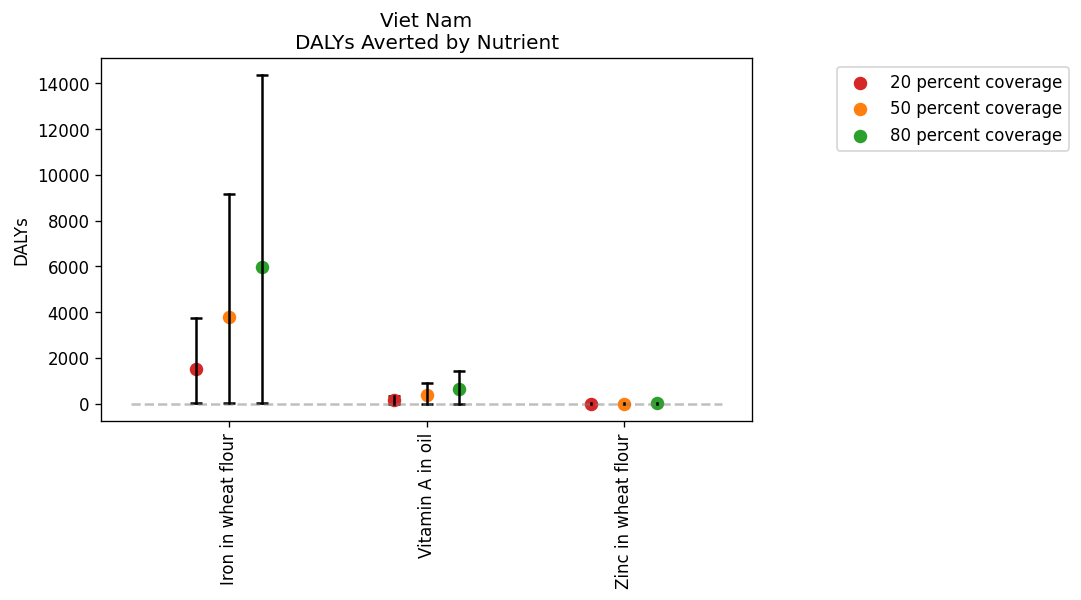

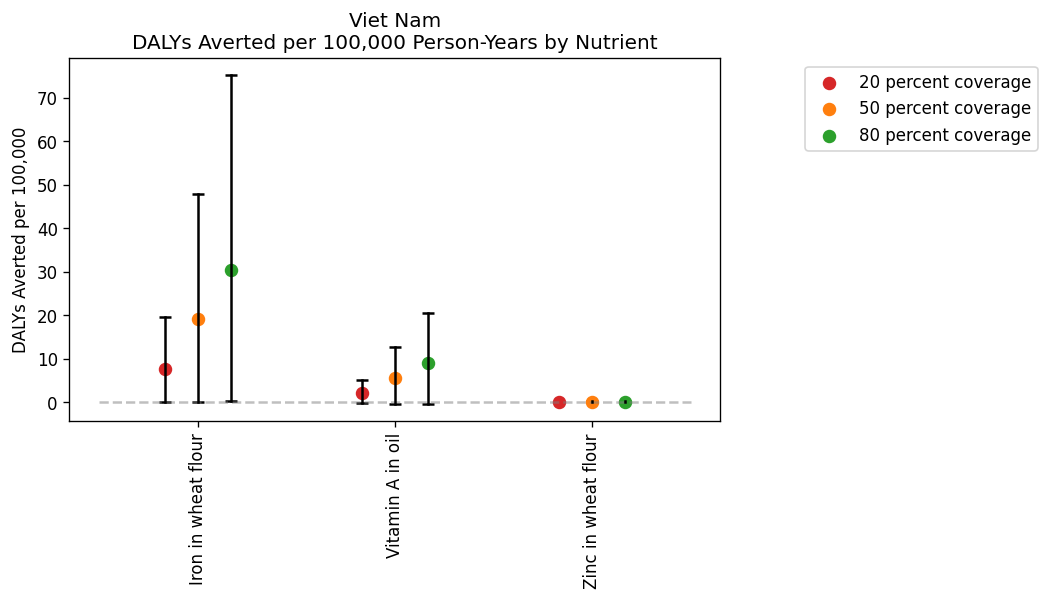

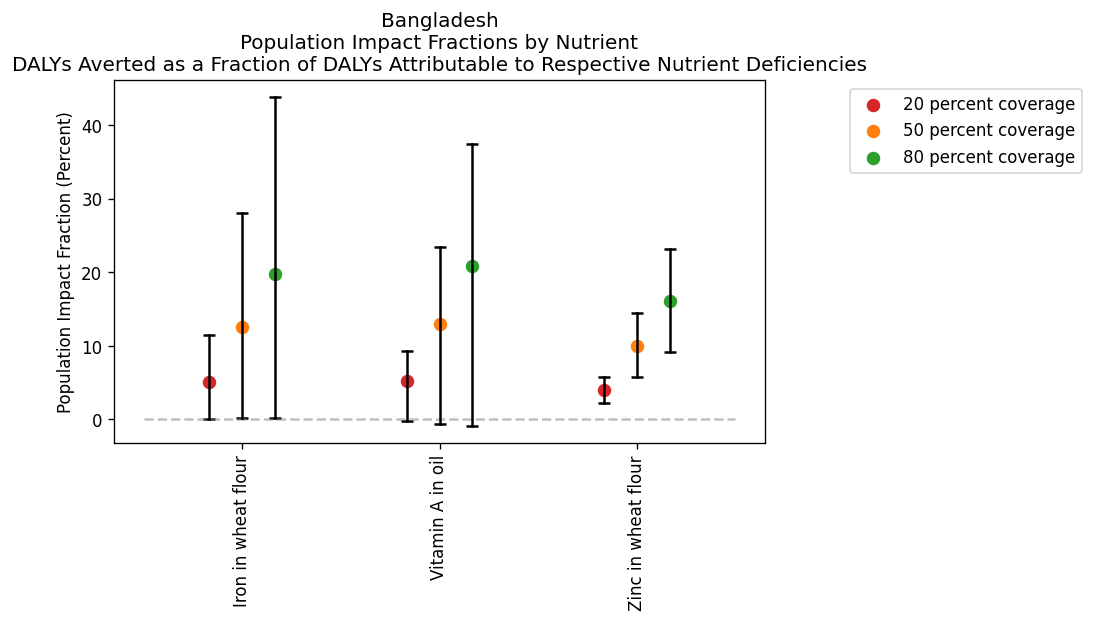

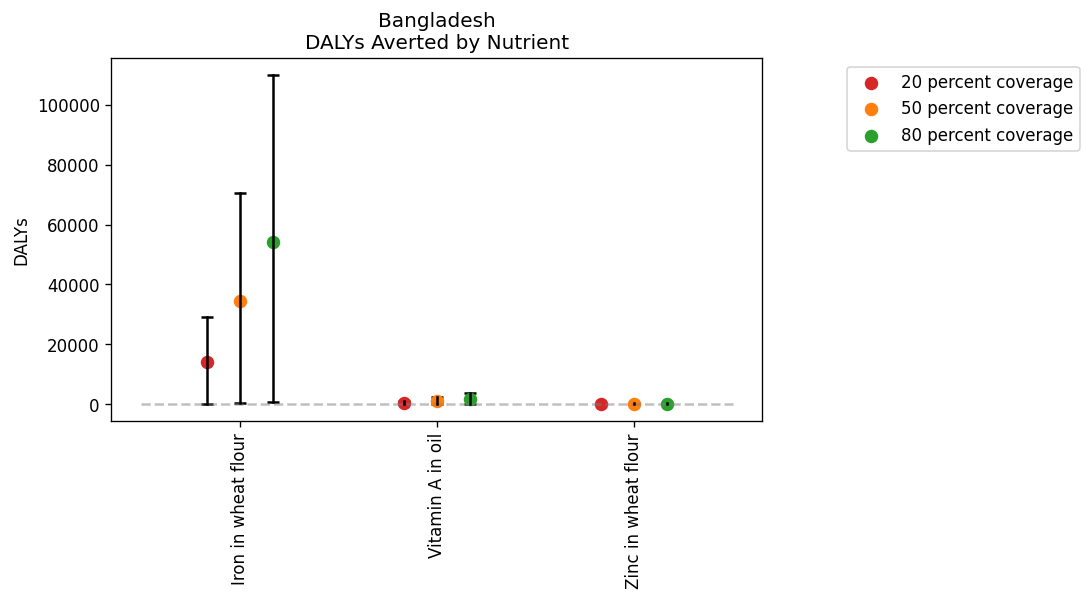

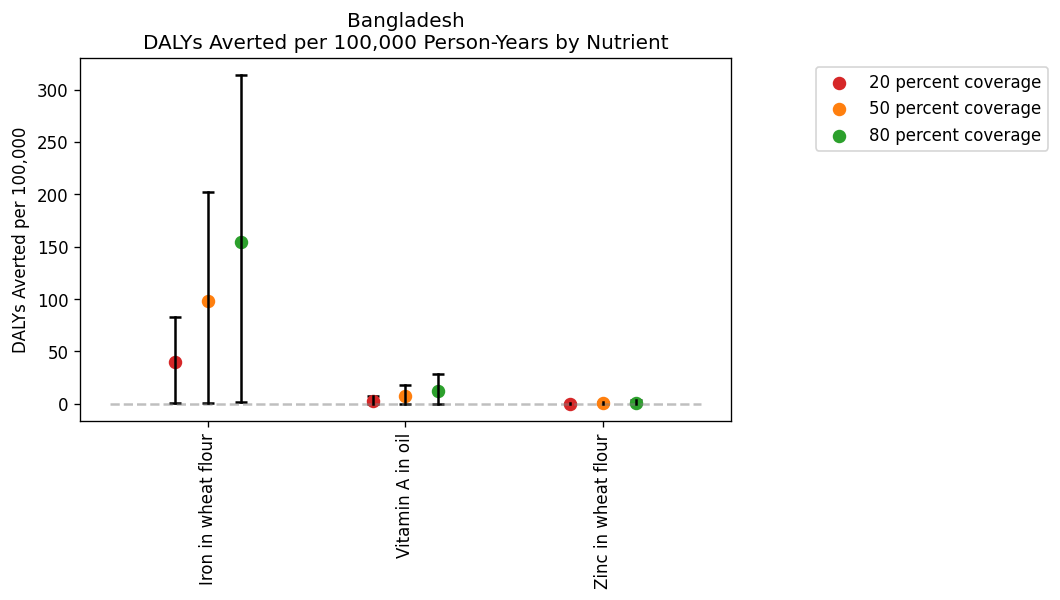

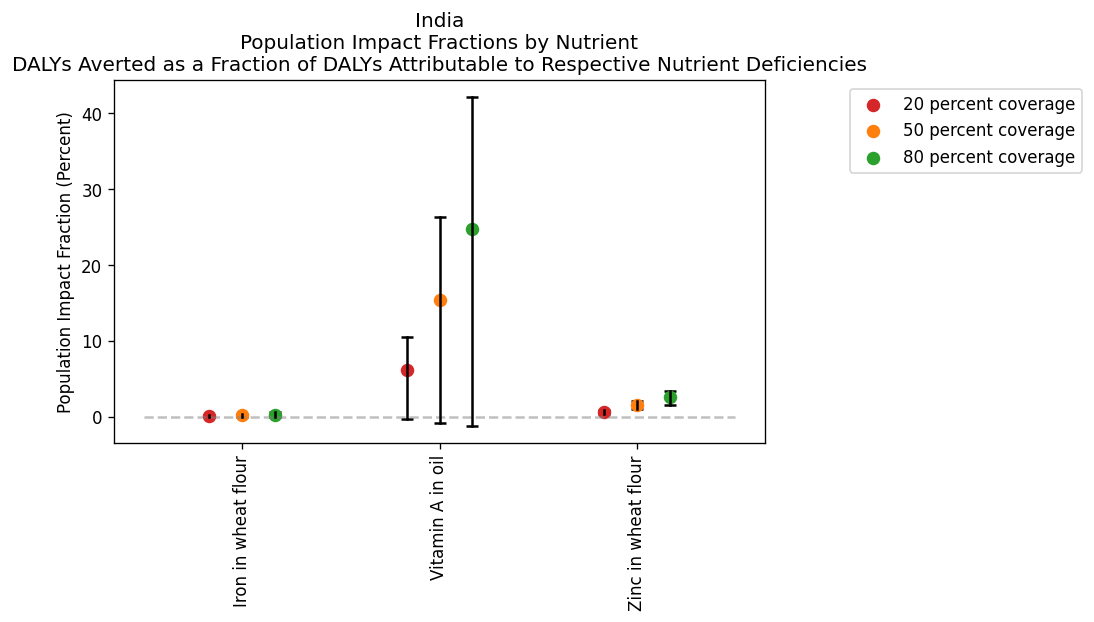

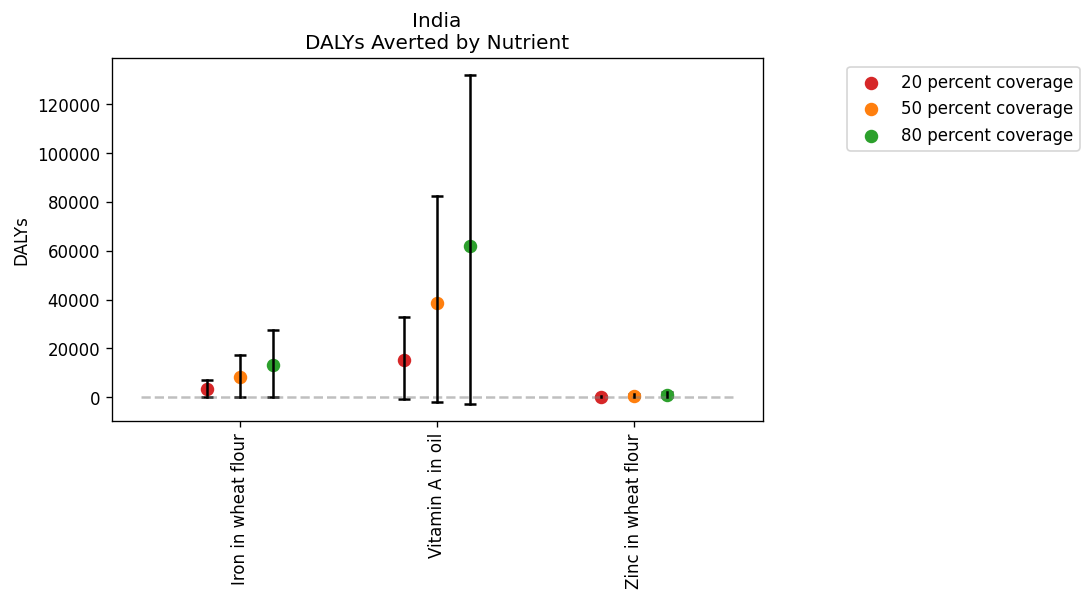

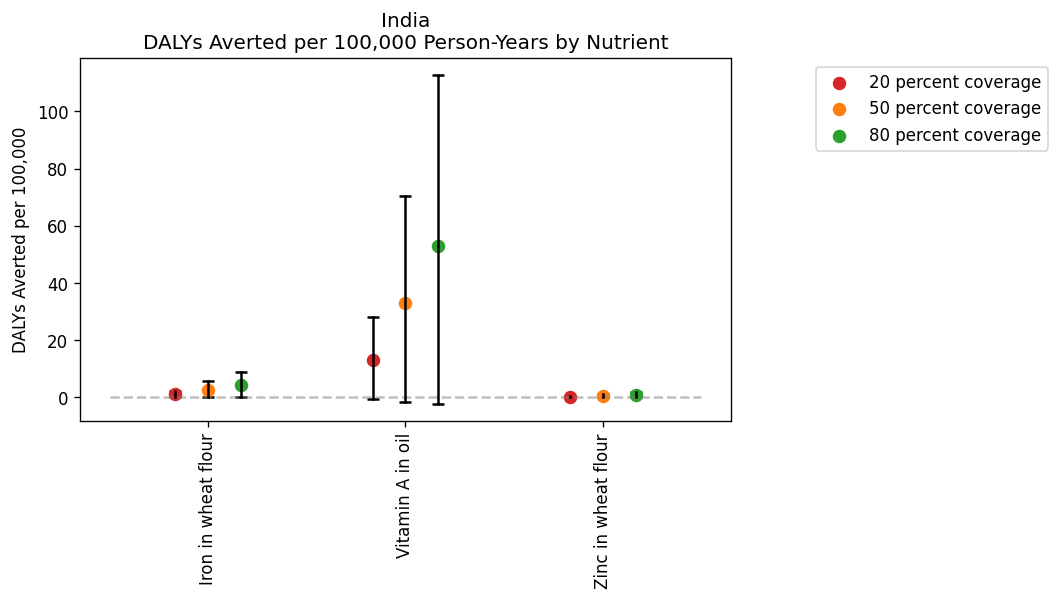

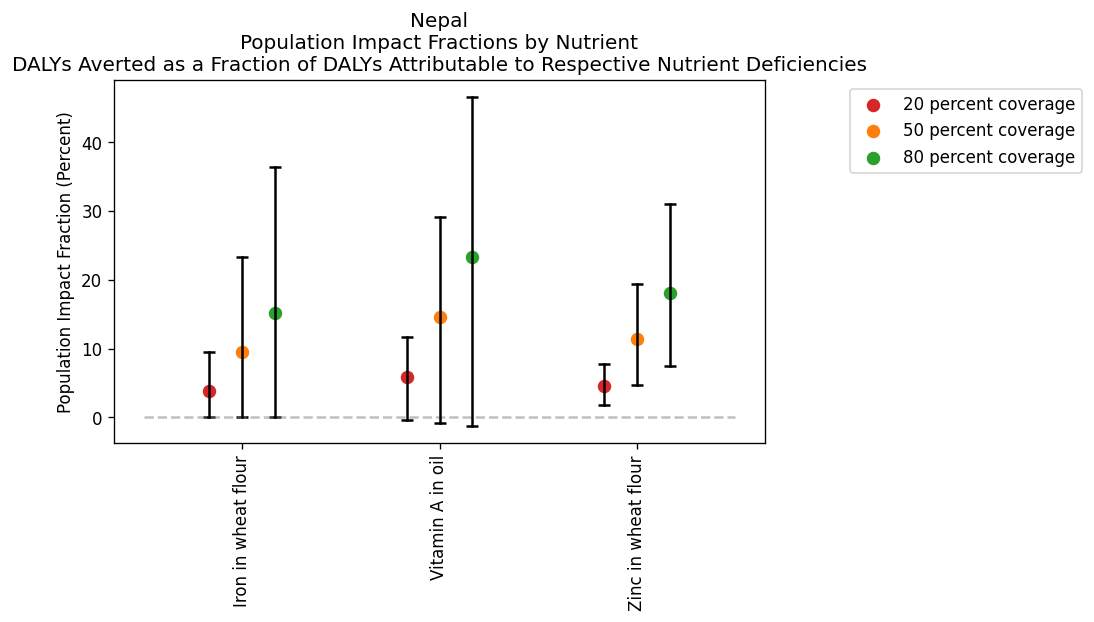

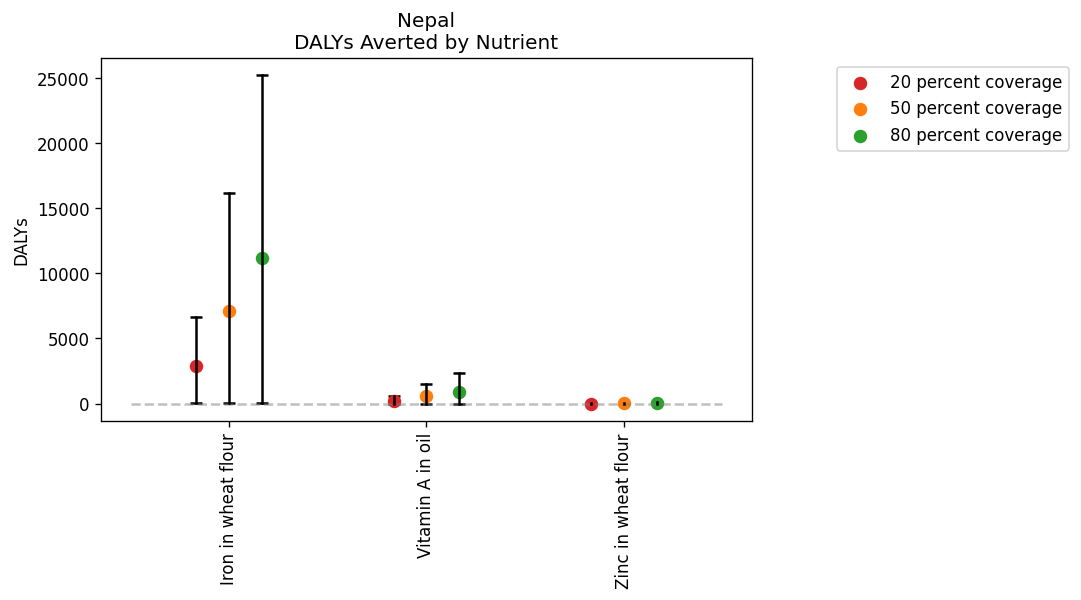

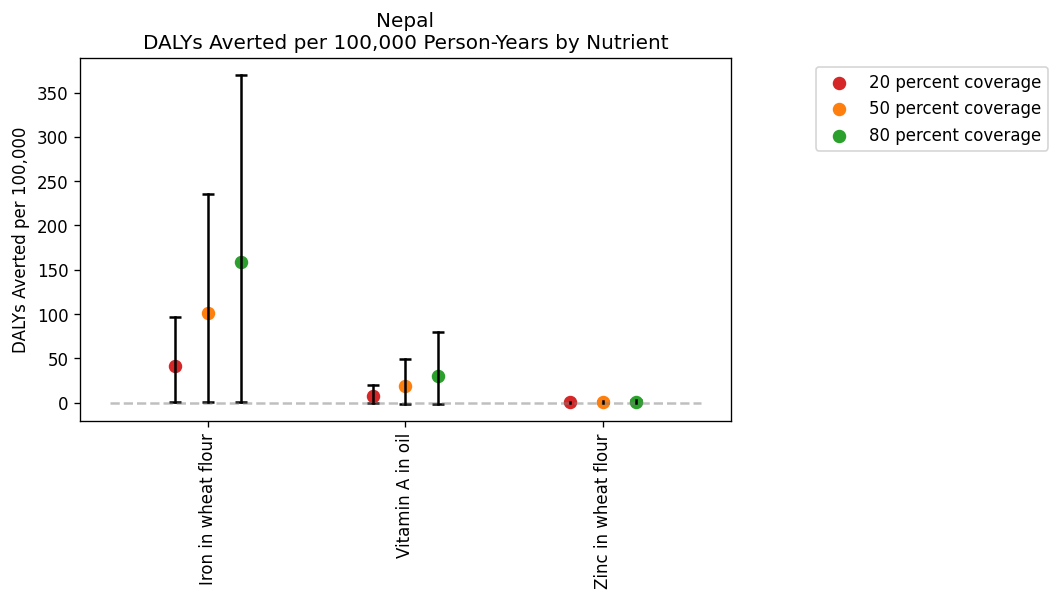

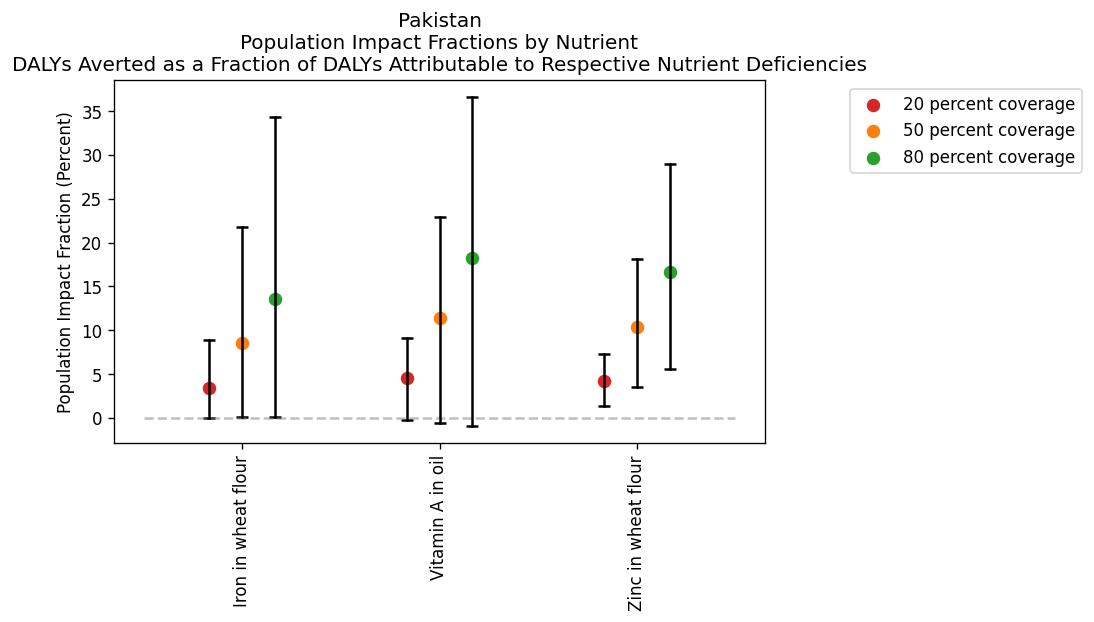

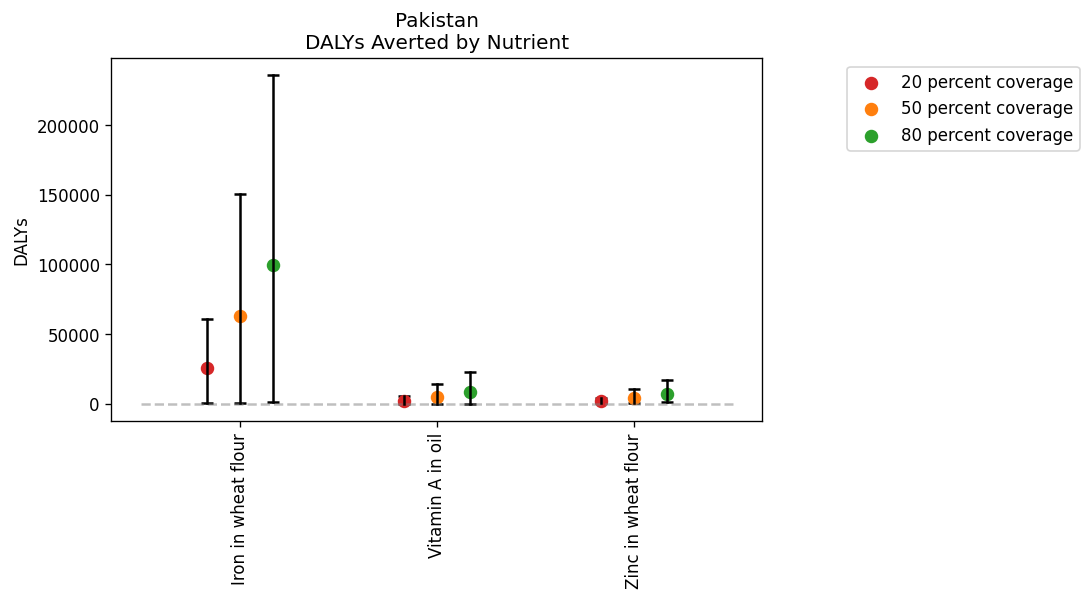

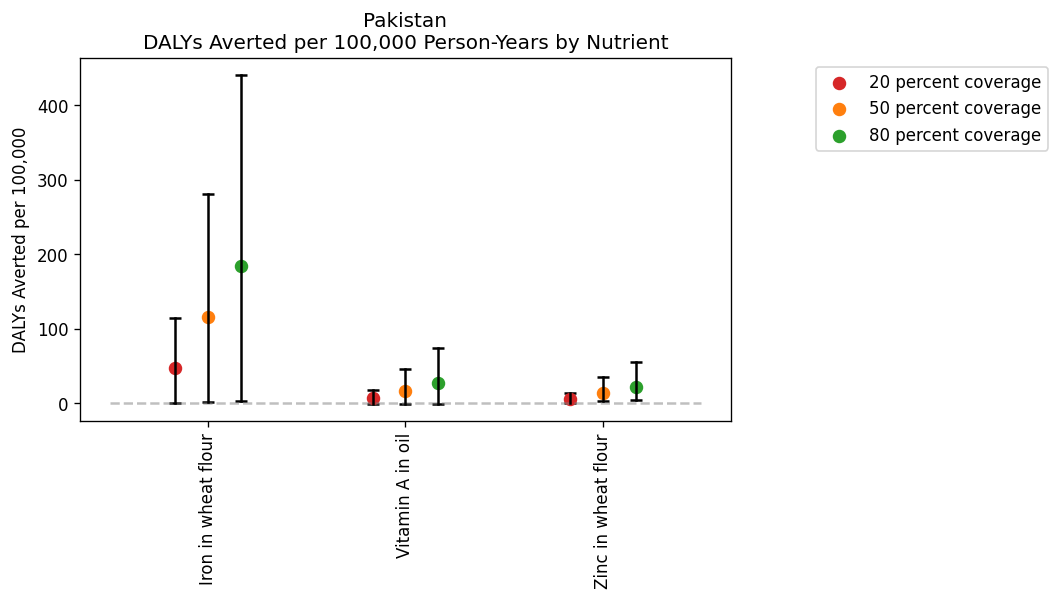

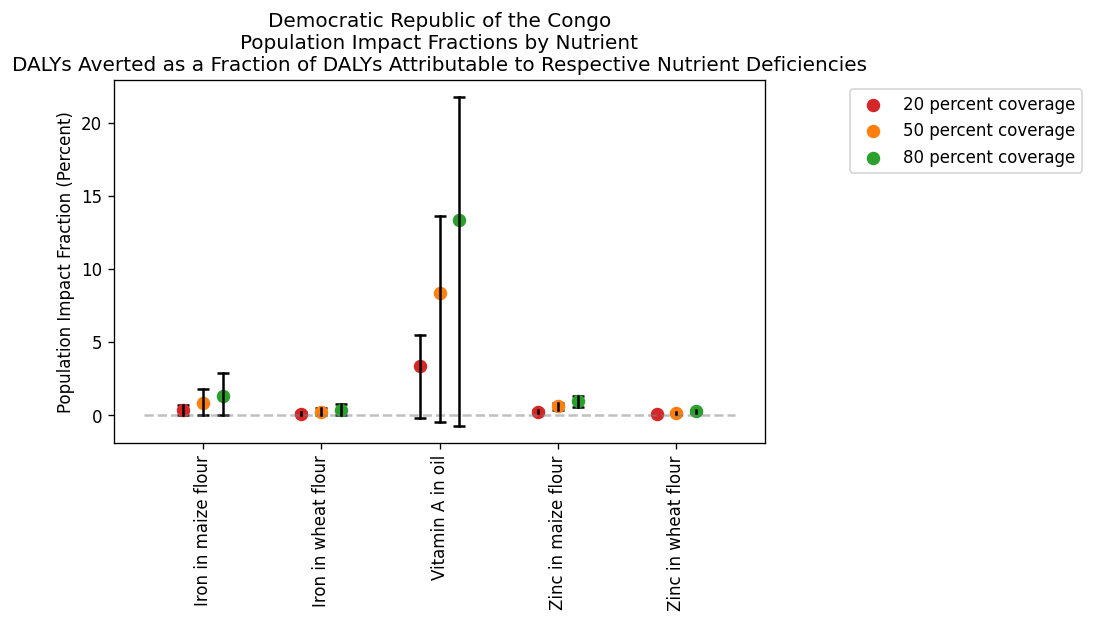

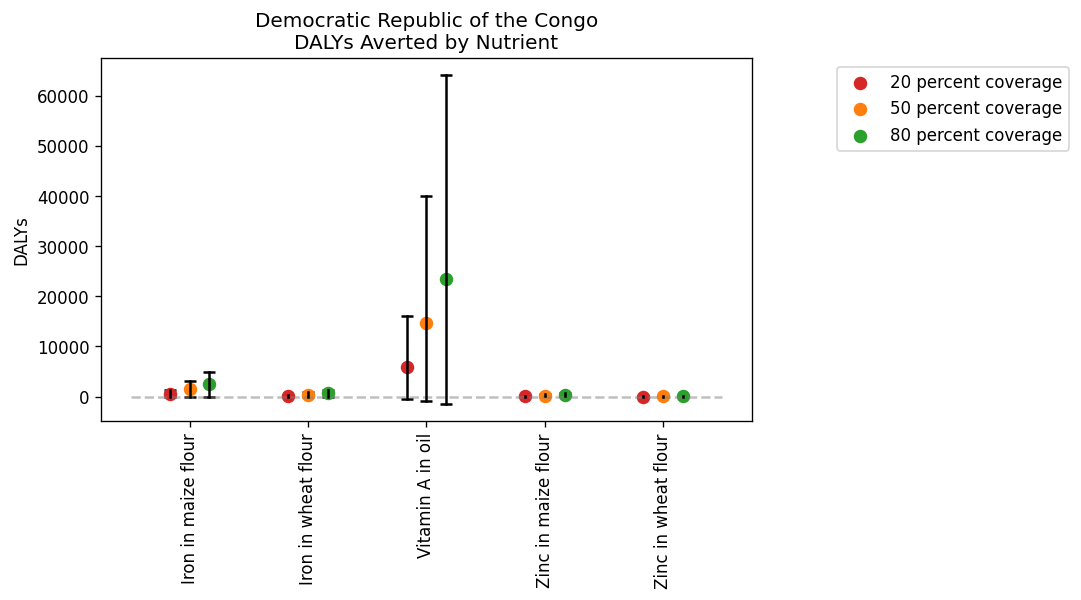

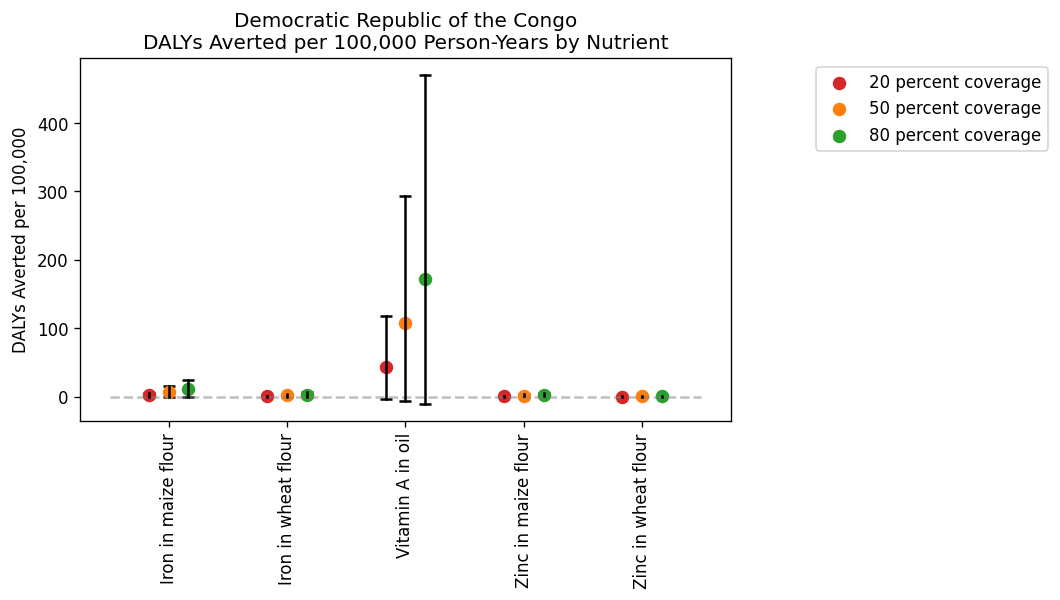

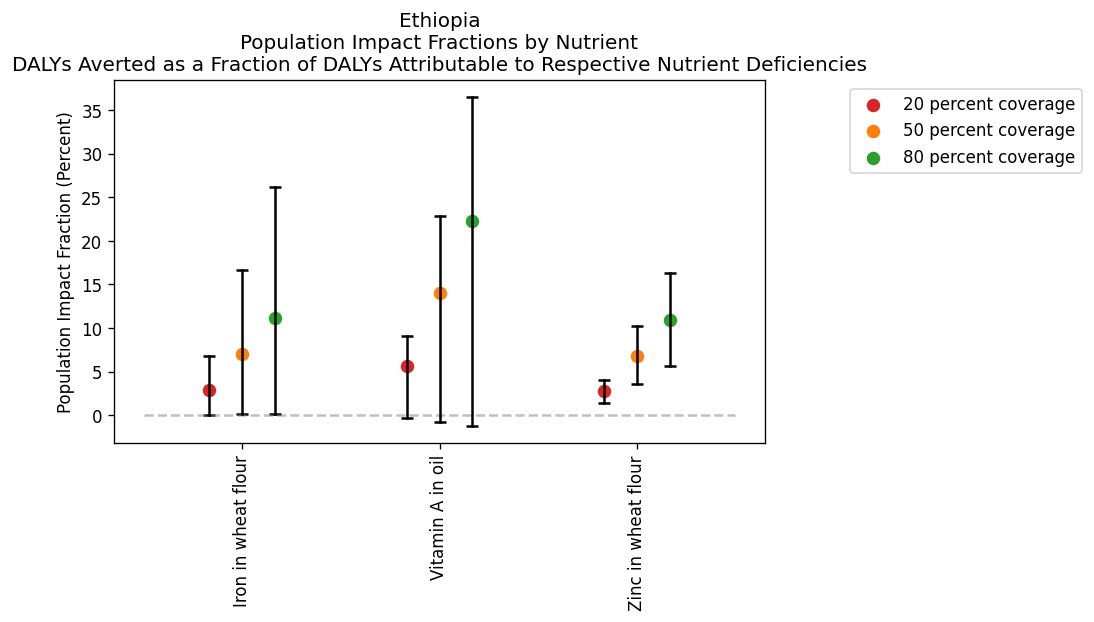

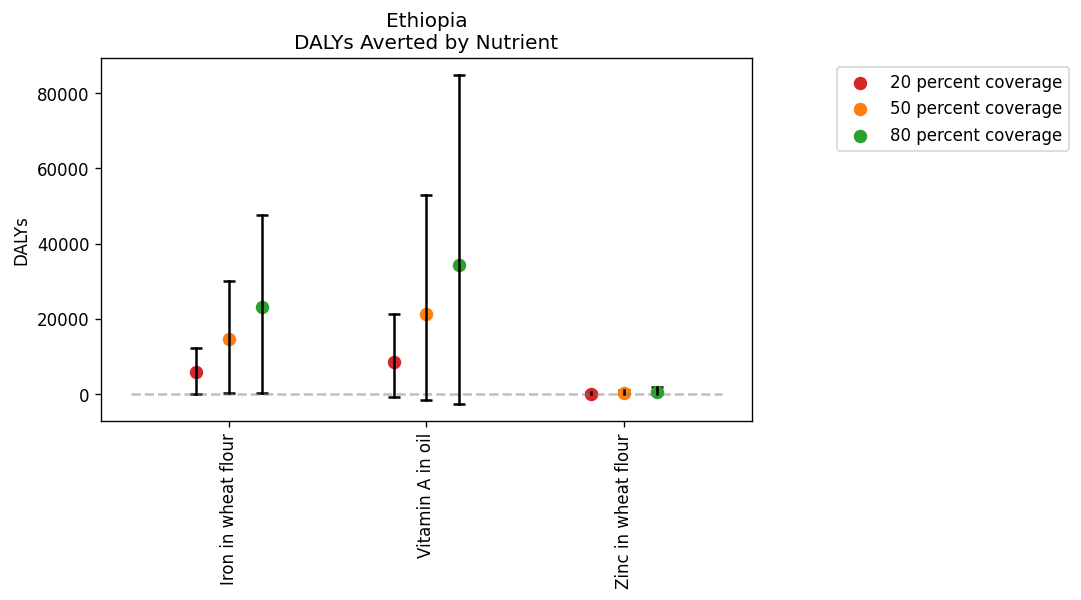

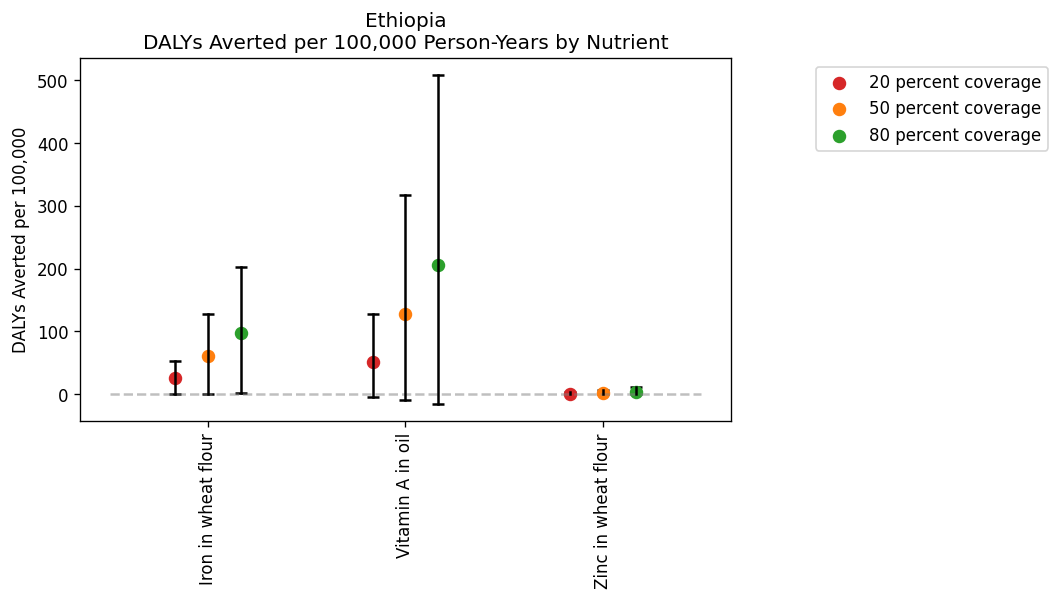

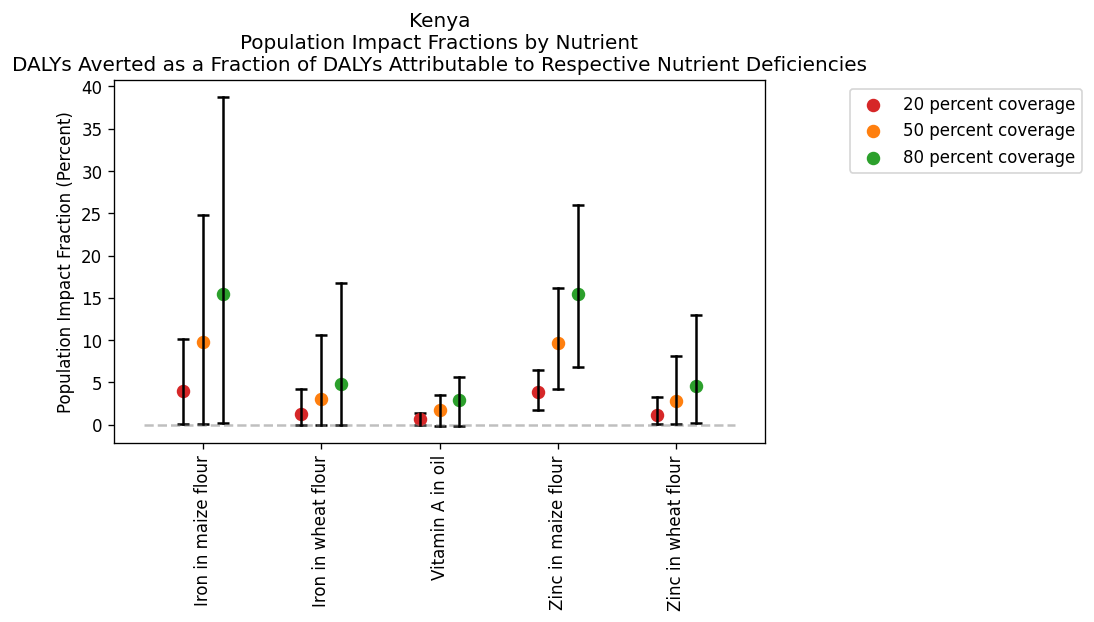

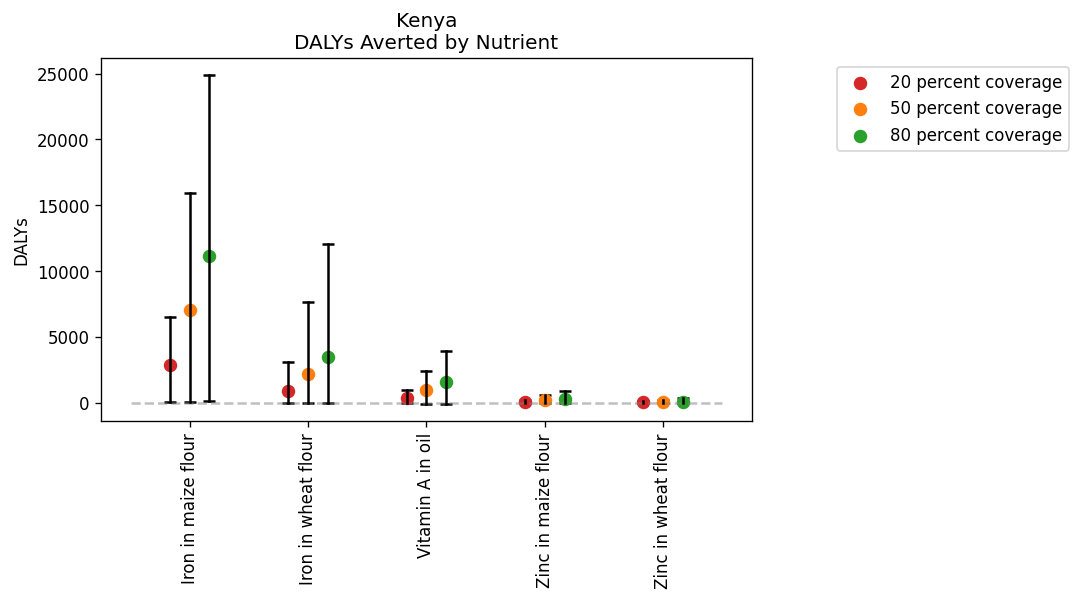

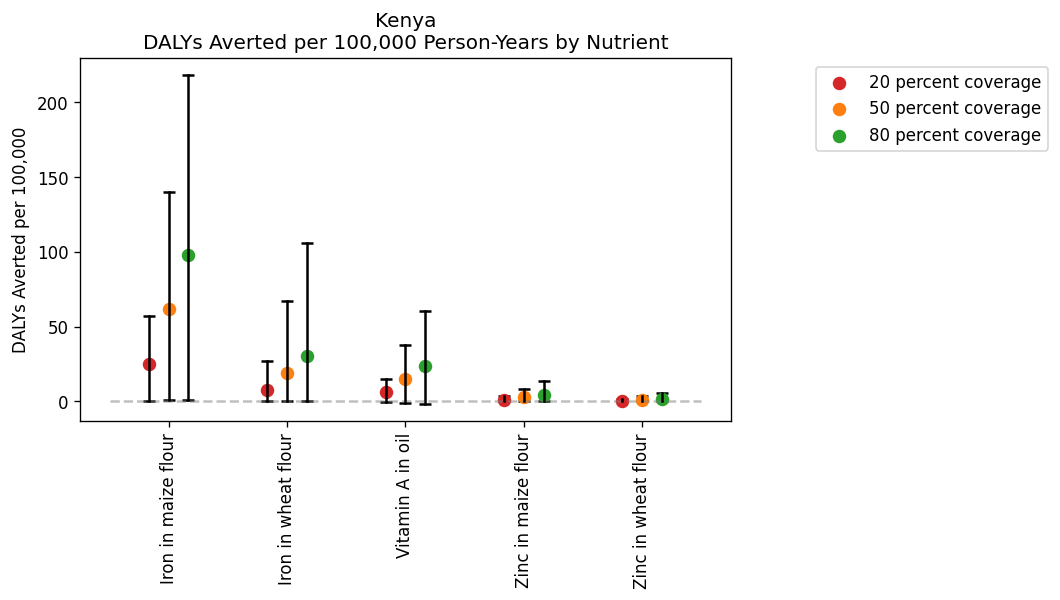

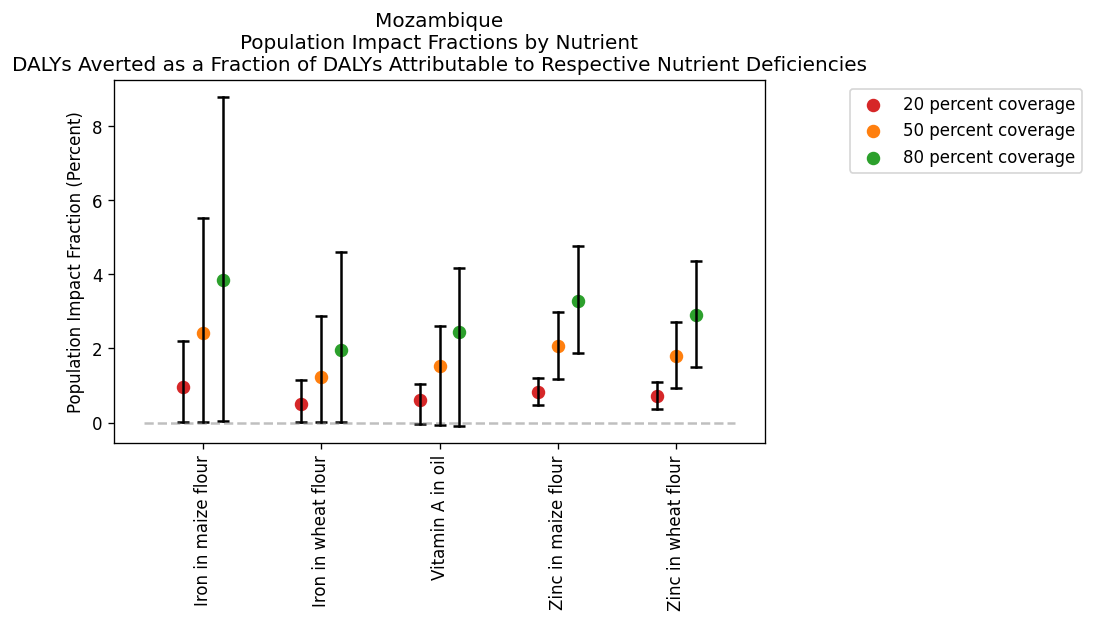

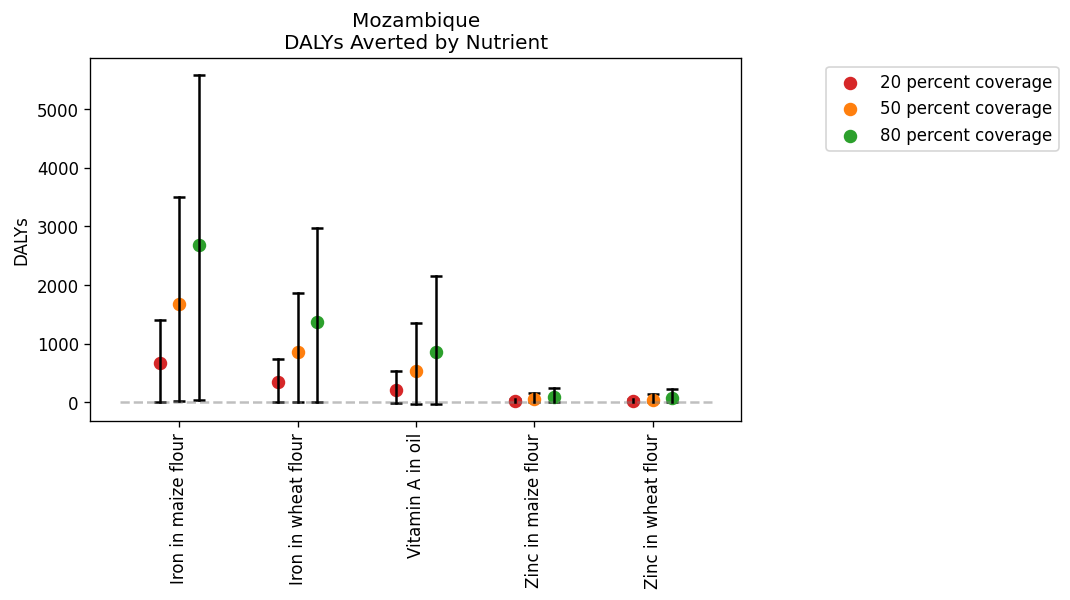

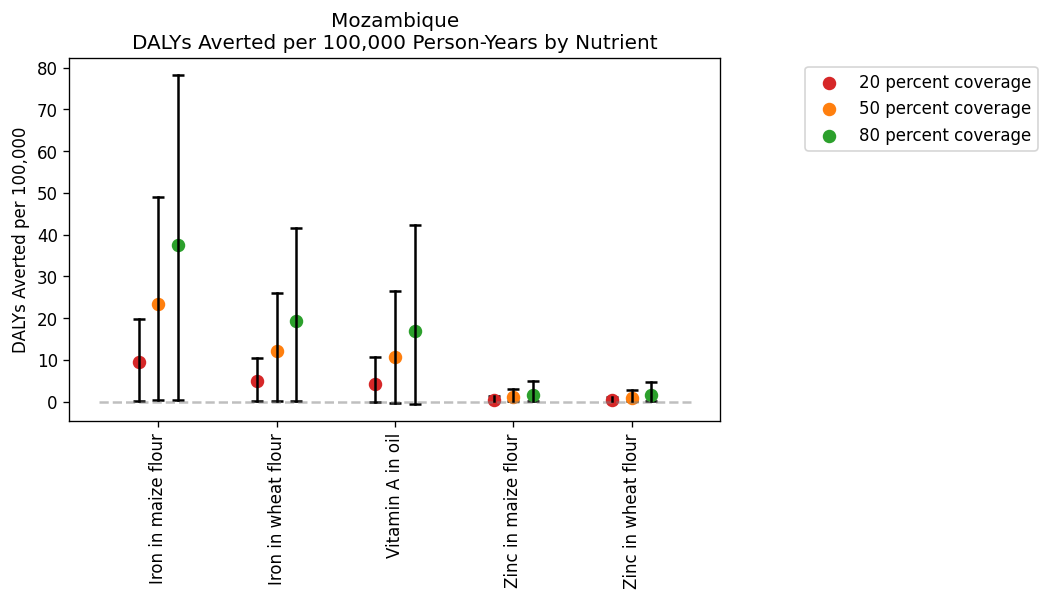

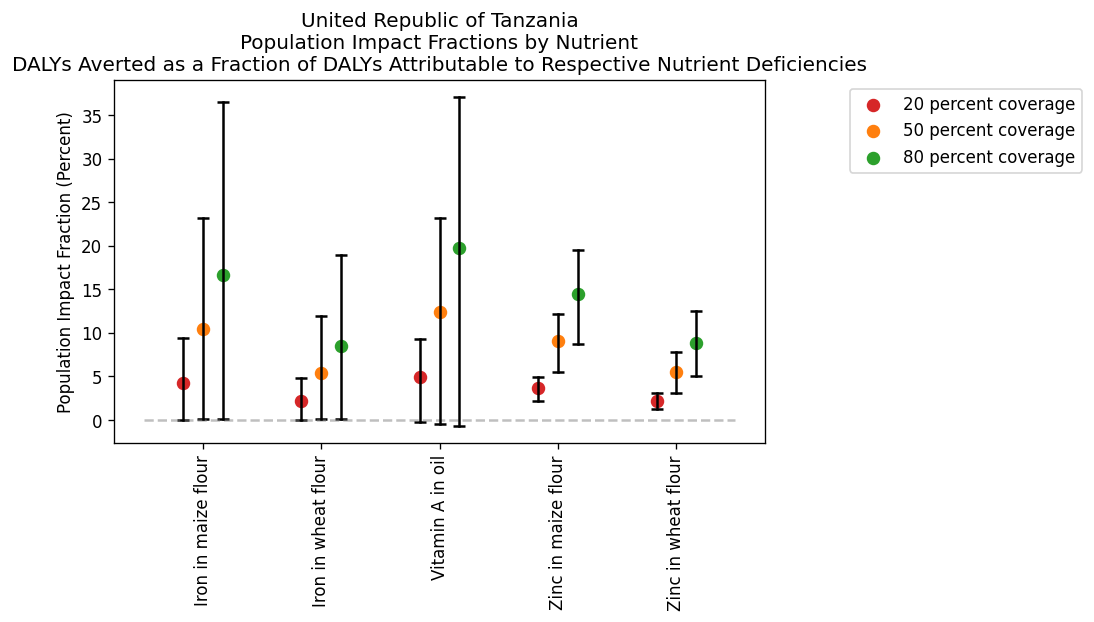

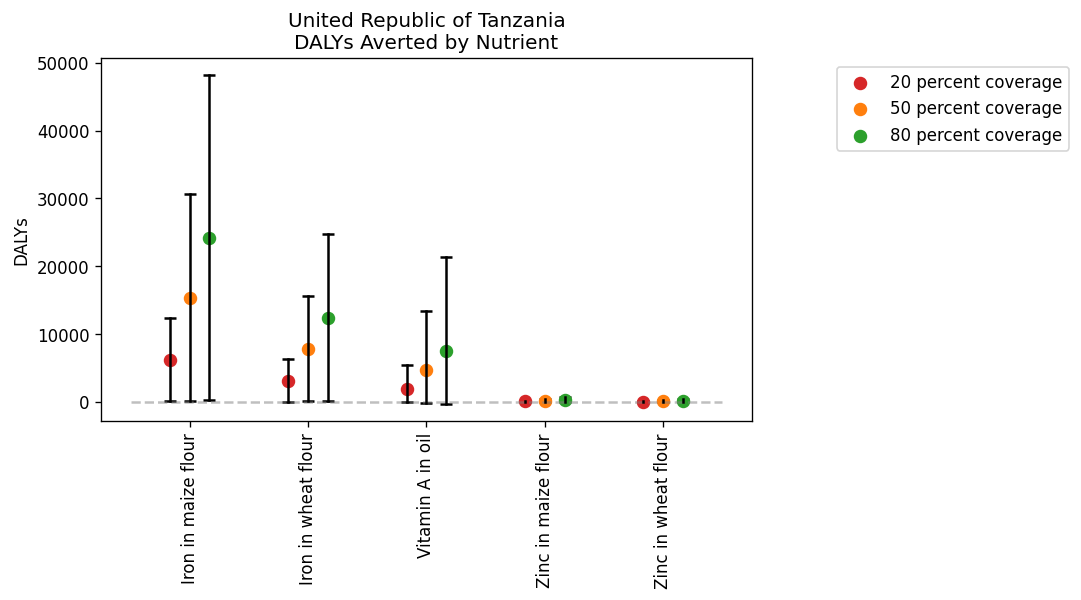

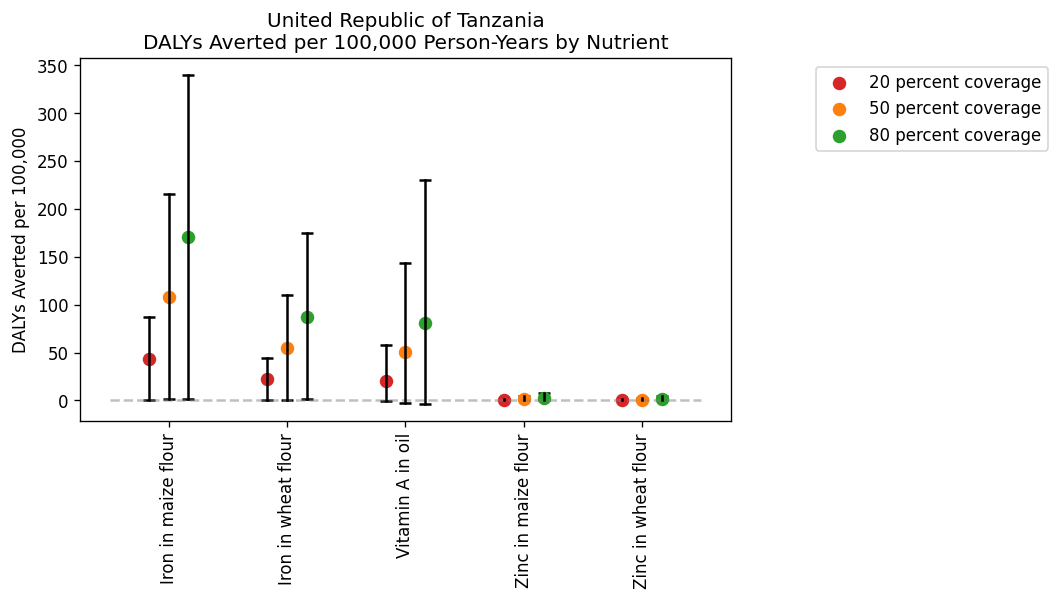

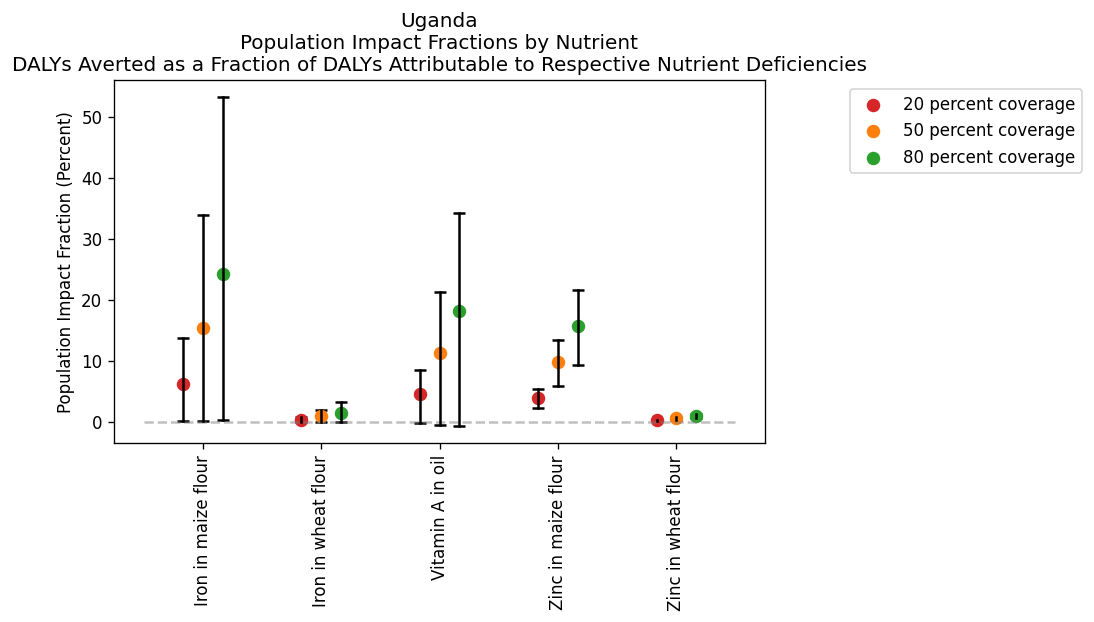

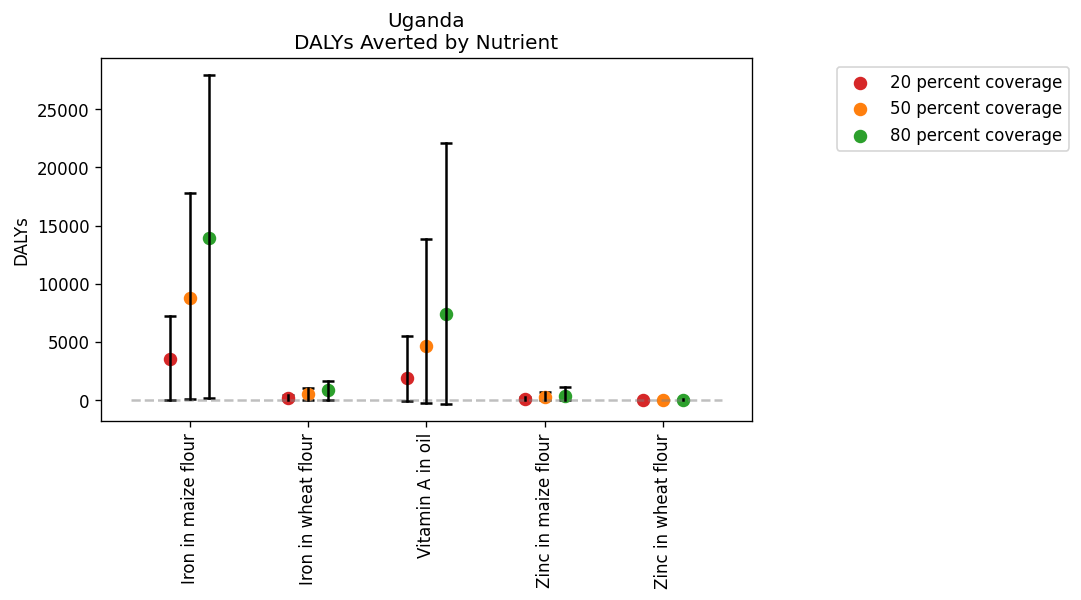

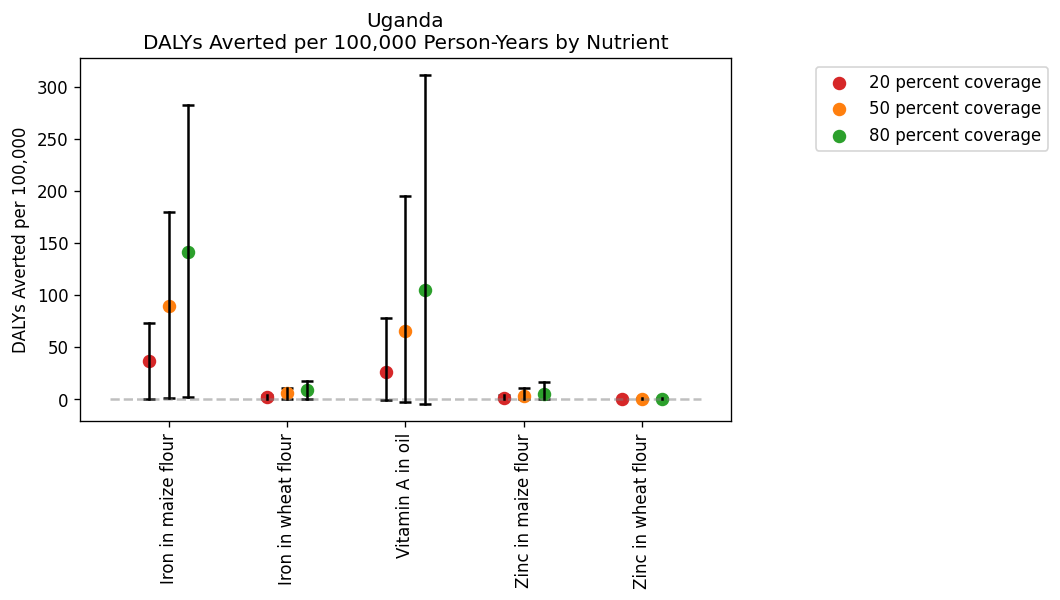

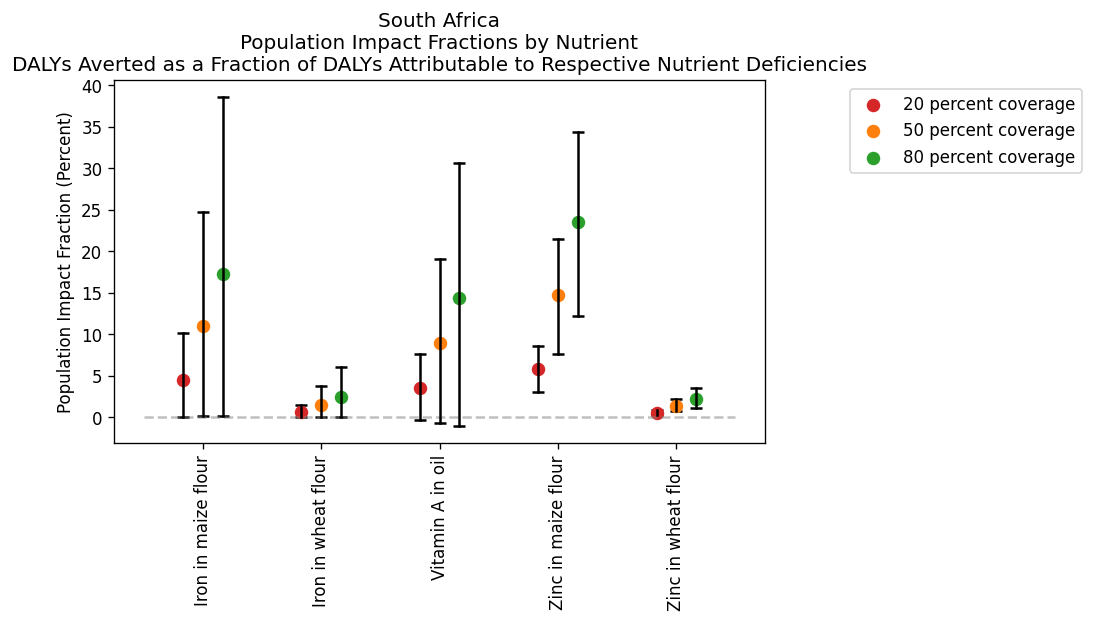

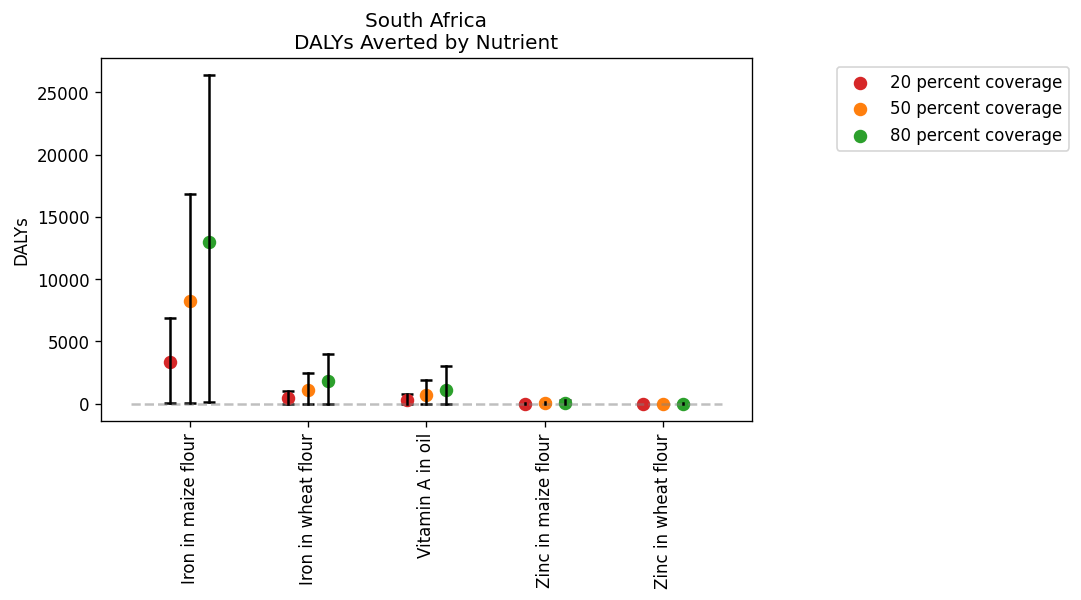

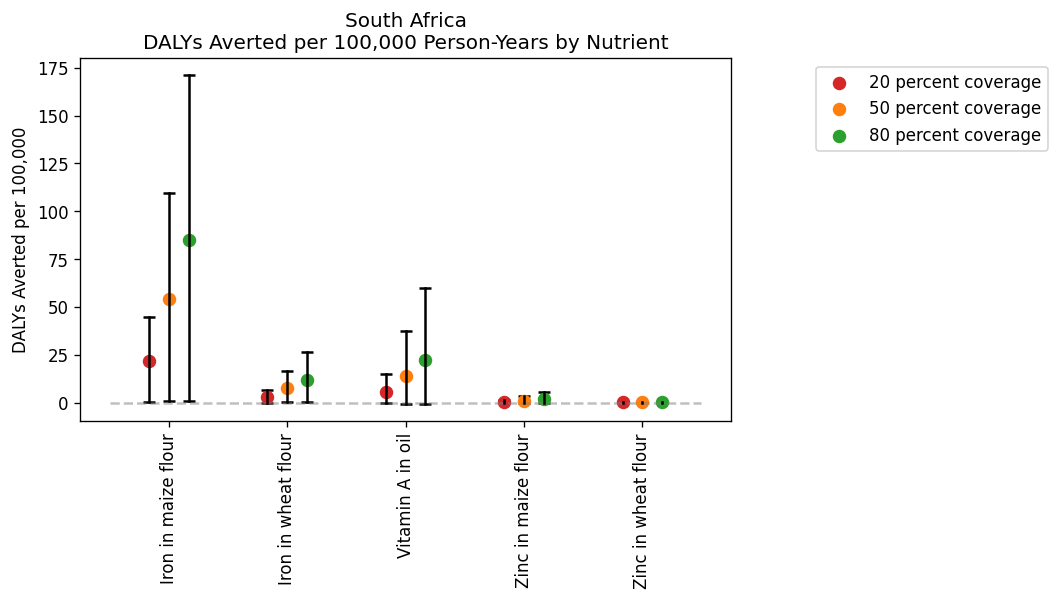

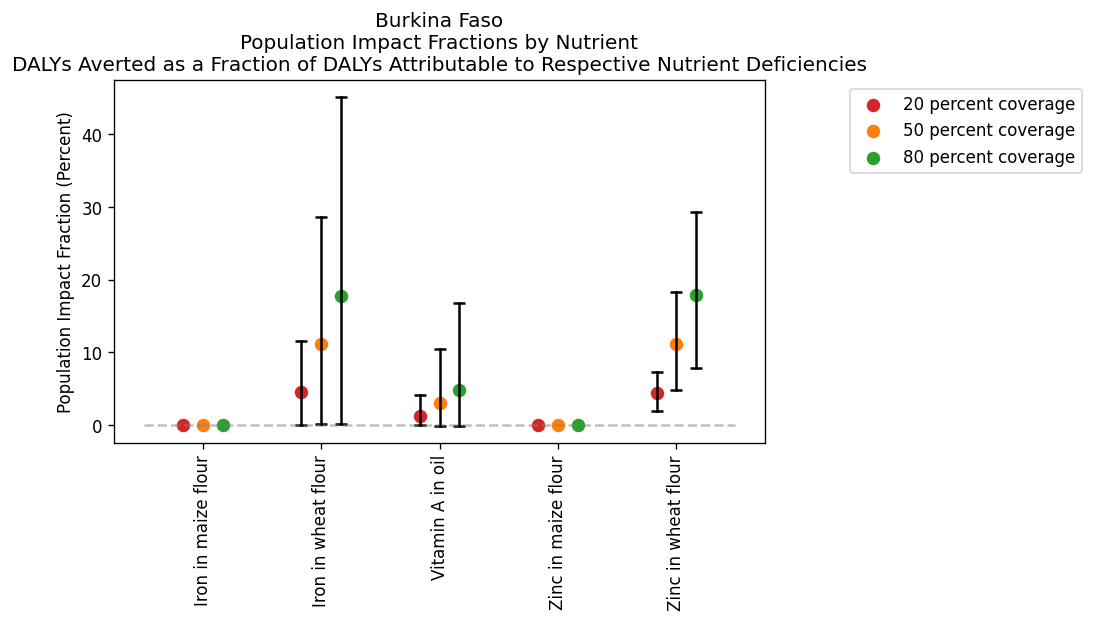

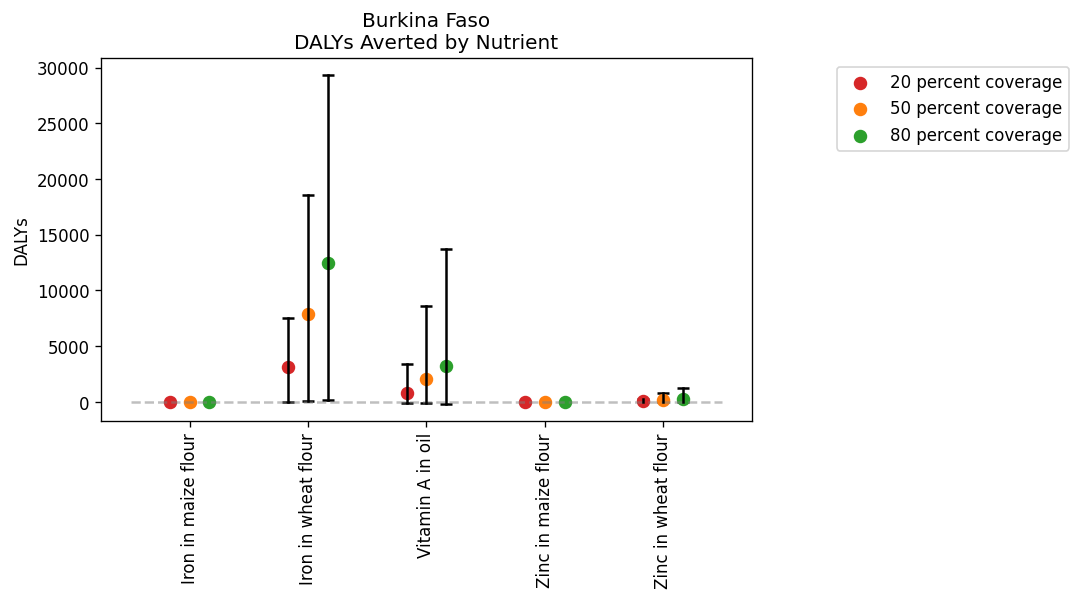

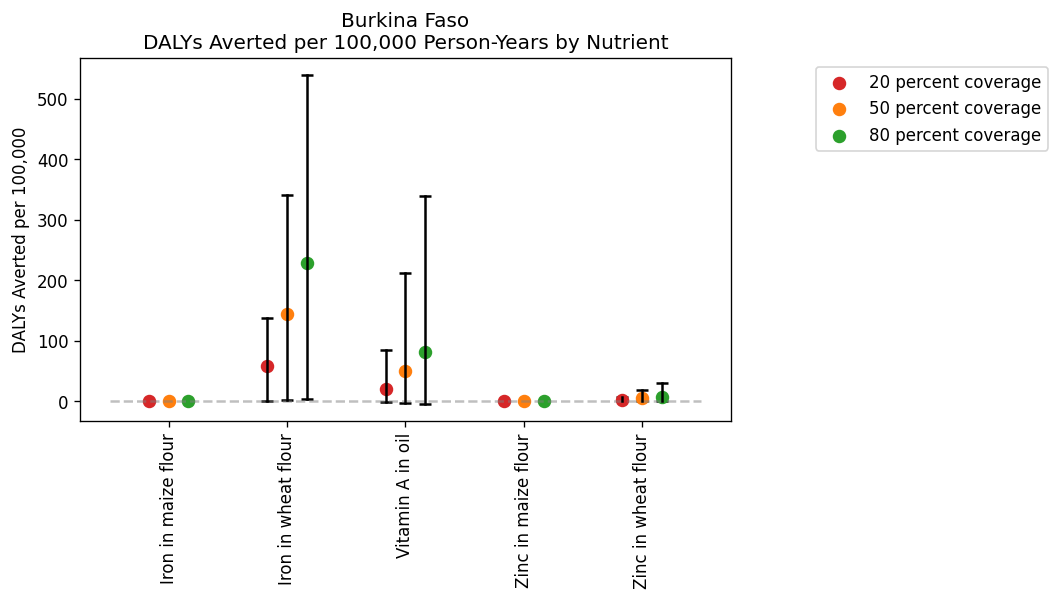

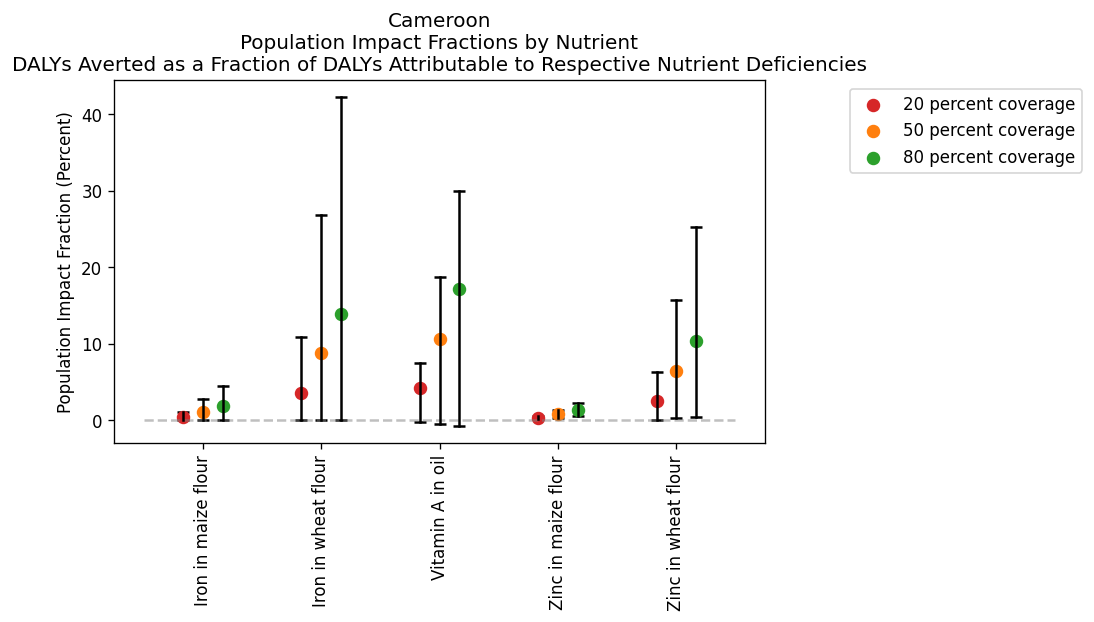

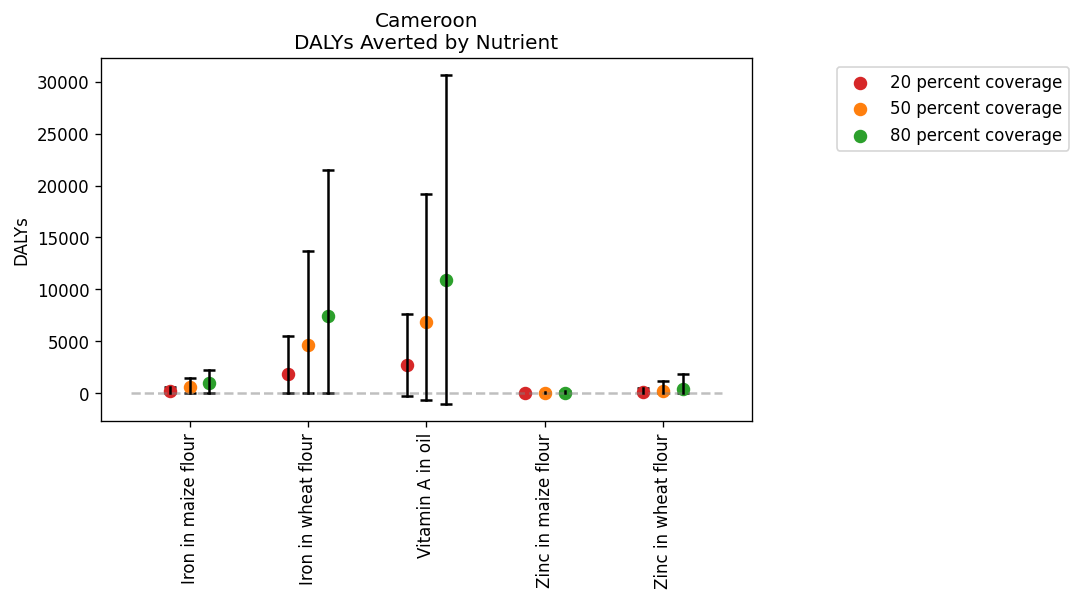

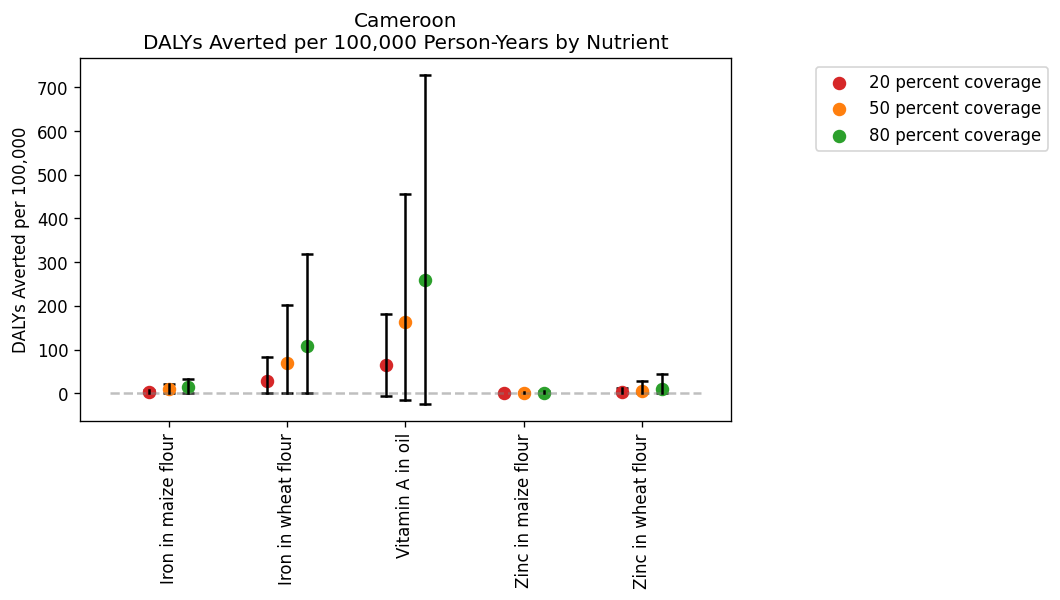

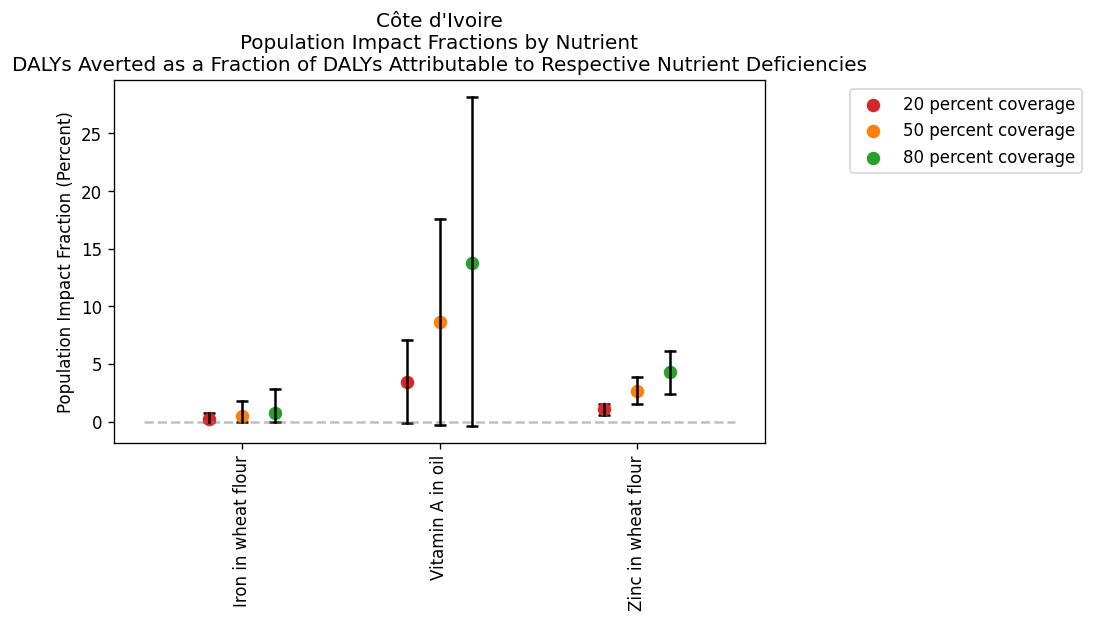

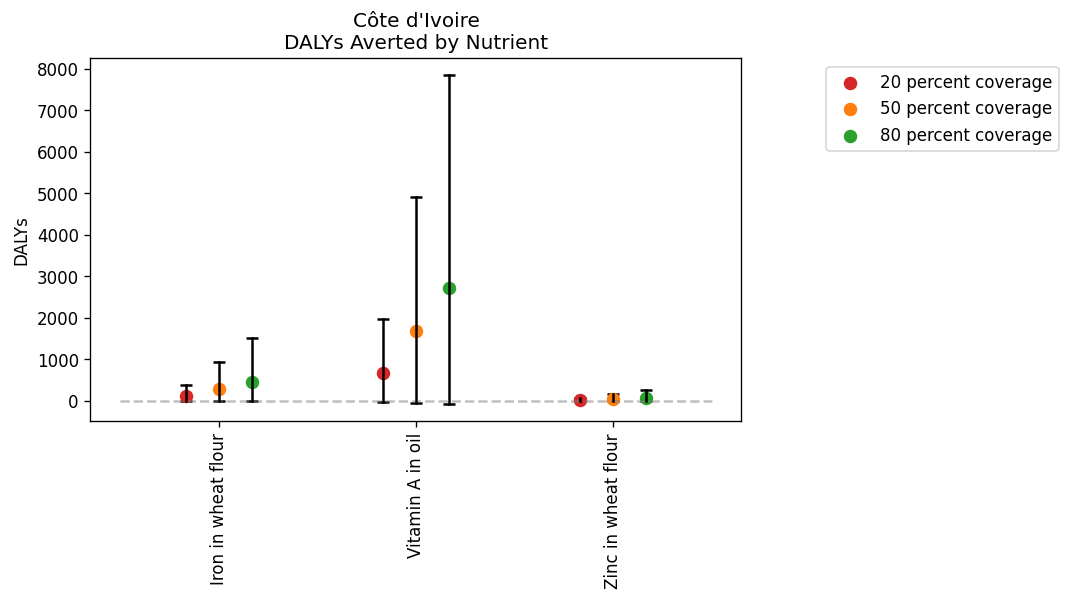

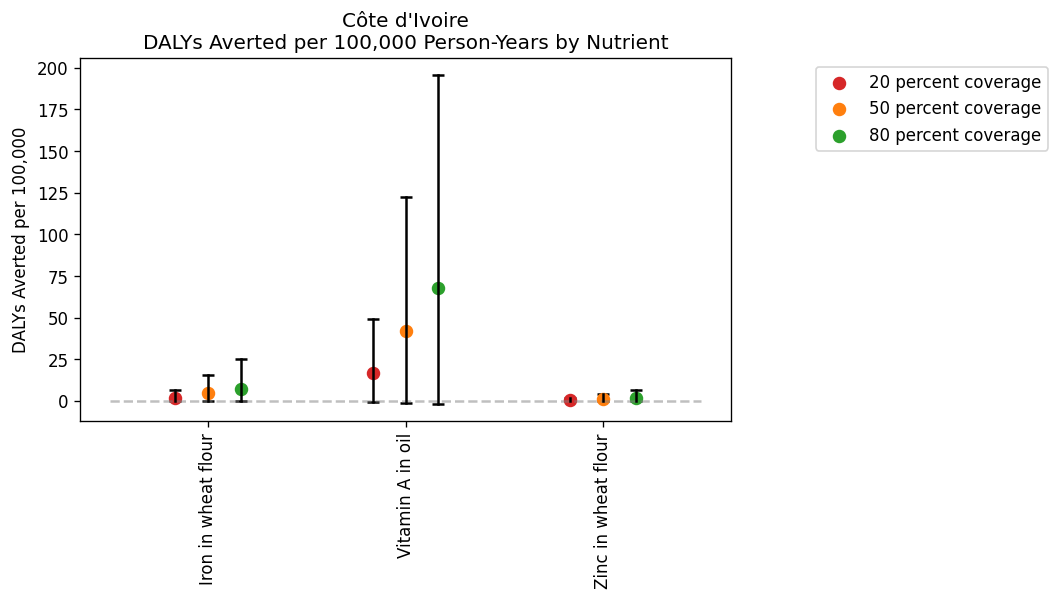

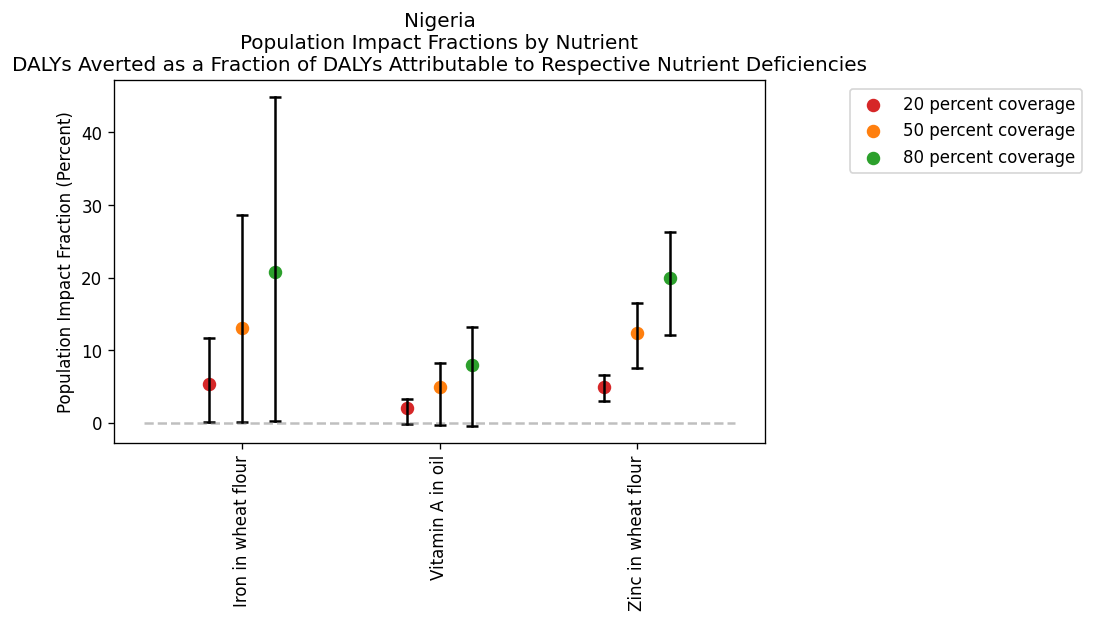

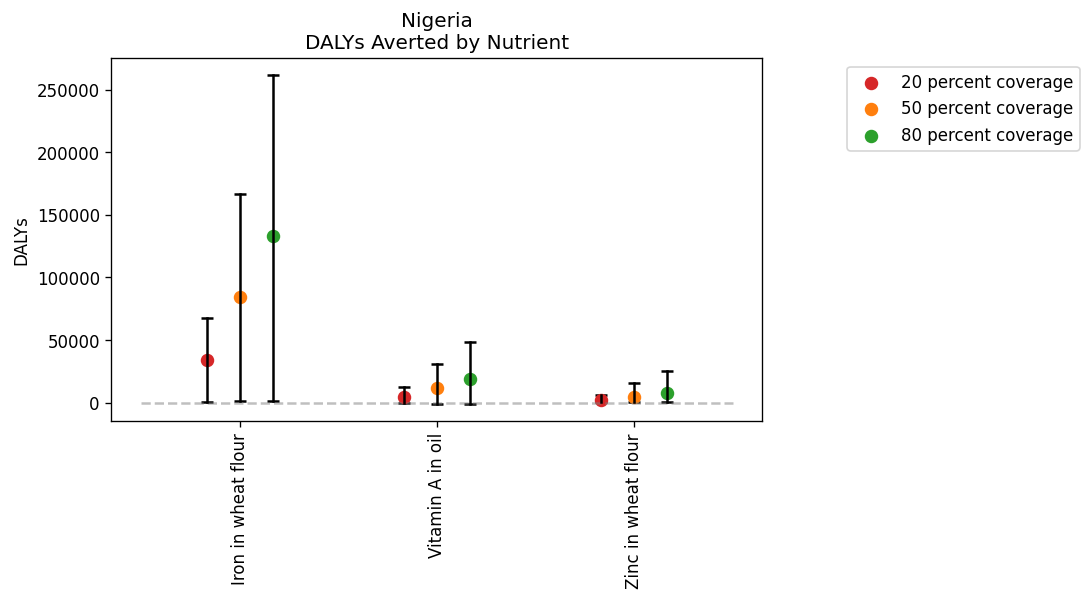

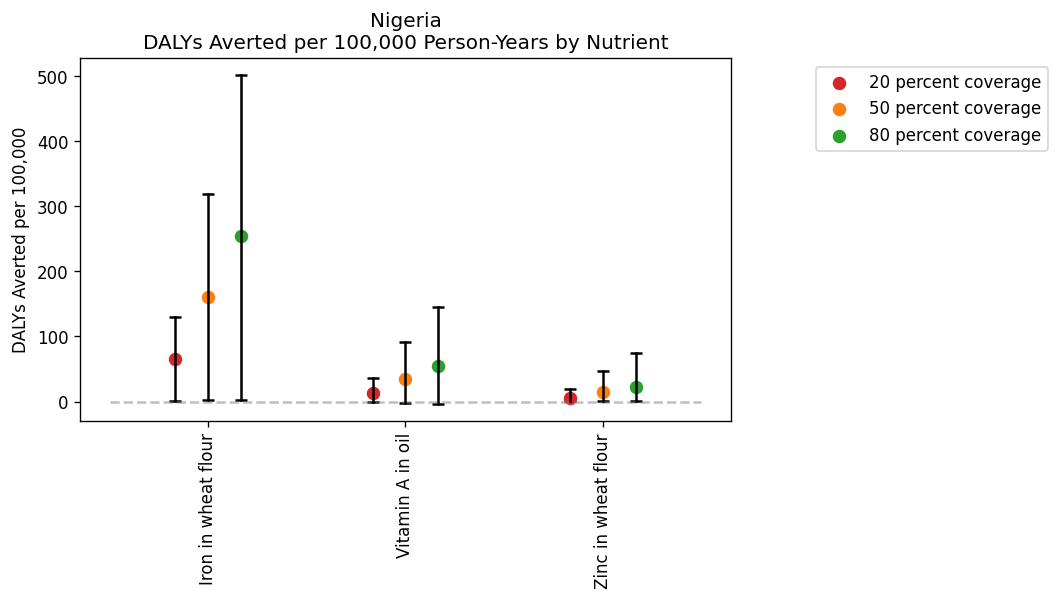

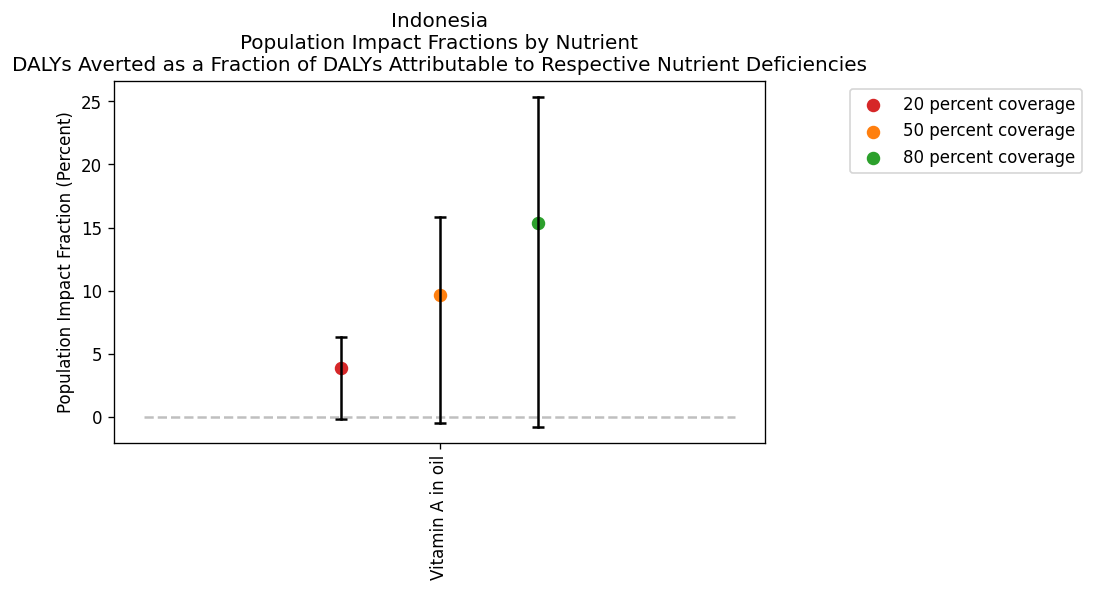

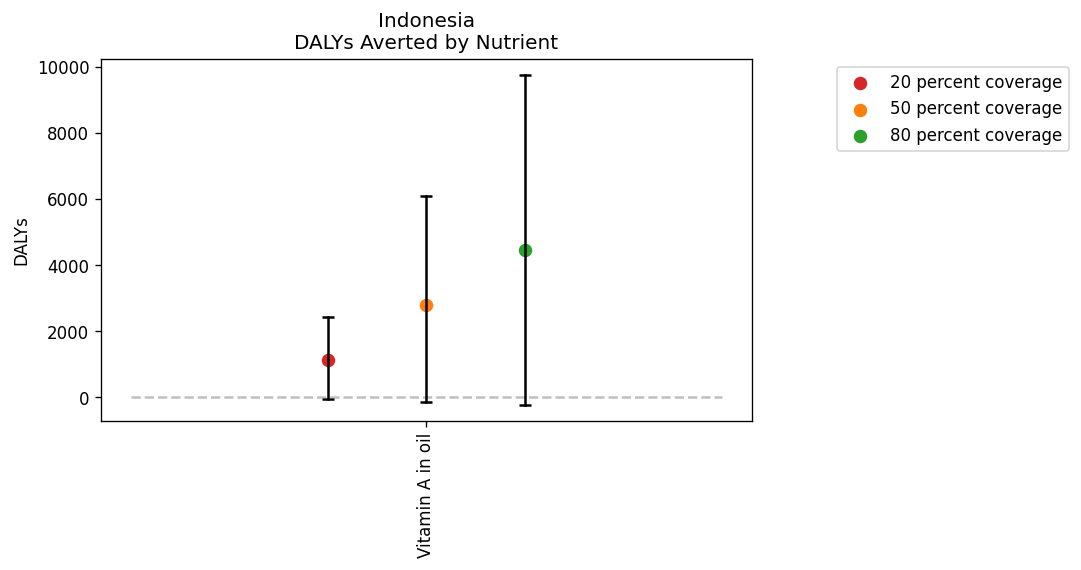

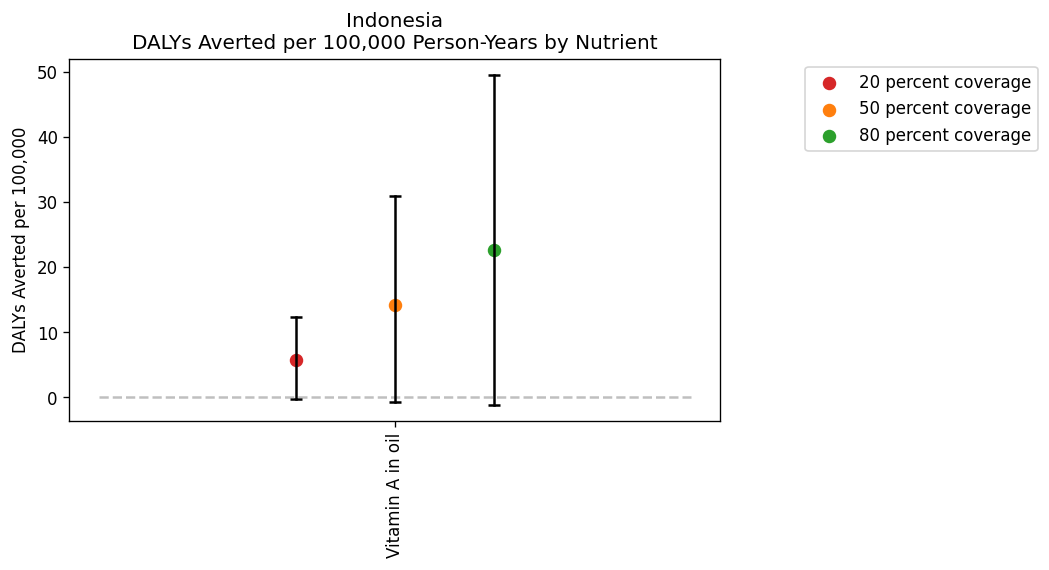

In [6]:
with PdfPages('results_plots/impact_by_location.pdf') as pdf:
    for location_id in results.location_id.unique():
        for measure in ['pif','counts_averted','rates_averted']:
            make_location_specific_plots(results, location_id, measure, coverage_levels)
            pdf.savefig(bbox_inches='tight')

# costs

In [7]:
# read in cost data
costs = pd.read_csv('raw_costs.csv')
costs.head()

location_name vehicle  five_year_cost  ten_year_cost
0                            Angola     oil           18.87          39.32
1                        Bangladesh     oil          131.12         277.66
2  Bolivia (Plurinational State of)     oil            4.93           9.57
3                      Burkina Faso     oil           16.98          34.66
4                           Burundi     oil            2.92           5.50

In [8]:
# merge location_ids
l = get_ids('location')
l = l.loc[l.location_type == 'admin0'].loc[l.location_id != 522]
cdi_name = l[l['location_id'] ==  205]['location_name'].values[0]
costs = costs.replace("Cote d'Ivoire", cdi_name)
costs_with_location_ids = costs.merge(l[['location_id','location_name']], on='location_name')

assert len(costs) == len(costs_with_location_ids), "Error: different number of rows after merging with location IDs"

costs_with_location_ids.head()

location_name      vehicle  five_year_cost  ten_year_cost  location_id
0        Angola          oil           18.87          39.32          168
1        Angola  maize flour           24.00          43.80          168
2        Angola  wheat flour            1.00           1.40          168
3    Bangladesh          oil          131.12         277.66          161
4    Bangladesh  wheat flour            5.20           9.90          161

In [9]:
measure = 'counts_averted'

results_icers = results.loc[results.measure == measure].loc[results.coverage_level == 0.8]
results_icers = (results_icers.merge(costs_with_location_ids, on=['location_id','vehicle','location_name']))
for i in list(range(0,1000)):
    results_icers[f'draw_{i}'] = (results_icers['ten_year_cost'] / 10) * 1_000_000 / results_icers[f'draw_{i}']
    
results_icers = results_icers.drop(columns=['five_year_cost','ten_year_cost'])
results_icers = results_icers.set_index([c for c in results_icers.columns if 'draw' not in c])
results_icers = results_icers.apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1).reset_index()
results_icers.head()

coverage_level  location_id         measure   nutrient      vehicle  \
0             0.8           15  counts_averted       zinc  wheat flour   
1             0.8           15  counts_averted       iron  wheat flour   
2             0.8           15  counts_averted  vitamin A          oil   
3             0.8           20  counts_averted       zinc  wheat flour   
4             0.8           20  counts_averted       iron  wheat flour   

     year nutrient_name location_name                label   count  \
0  2025.0          Zinc       Myanmar  Zinc in wheat flour  1000.0   
1  2025.0          Iron       Myanmar  Iron in wheat flour  1000.0   
2  2025.0     Vitamin A       Myanmar     Vitamin A in oil  1000.0   
3  2025.0          Zinc      Viet Nam  Zinc in wheat flour  1000.0   
4  2025.0          Iron      Viet Nam  Iron in wheat flour  1000.0   

           mean            std           min          2.5%           50%  \
0           inf            NaN  3.750725e+03   7046.092717  31015.058483   
1  4.051063e+01    1209.125399 -3.385307e+04     17.377048     59.123205   
2  8.092005e+04  527227.760157 -4.572603e+06 -79525.639998  37300.705976   
3           inf            NaN  3.025734e+03   6951.691627  31678.282178   
4  2.915196e+01     656.305159 -1.776034e+04      9.552438     33.819984   

          97.5%           max  
0  1.080807e+06           inf  
1  4.011111e+02  5.287495e+03  
2  3.451142e+05  1.123319e+07  
3           inf           inf  
4  2.686371e+02  4.367519e+03

In [10]:
vehicles = ['oil','maize flour','wheat flour']

# print location ids that were excluded due to lack of cost data for each vehicle
print('Location IDs excluded due to lack of cost data for each vehicle')
for vehicle in vehicles:
    exclusions = ([c for c in list(results.loc[results.vehicle == vehicle].location_id.unique())
                     if c not in list(results_icers.loc[results_icers.vehicle == vehicle].location_id.unique())])
    print(f'{vehicle}: {exclusions}')

Location IDs excluded due to lack of cost data for each vehicle
oil: []
maize flour: [171, 184, 201, 202]
wheat flour: [190]


In [11]:
def make_cost_per_daly_plots(data, vehicle, nutrient, value_cap, uncertainty=True):
    df = (data
                .loc[data.vehicle == vehicle]
                .loc[data.nutrient == nutrient]
                .loc[data['50%'] <= value_cap]
                .sort_values(by='50%'))
    
    f, ax = plt.subplots(figsize=(7, 4), dpi=120)
    colors = ['tab:red', 'tab:orange', 'tab:green']

    location_spacer = 0.15
    x_vals = []
    for i in list(range(0, len(df))):
        if uncertainty: 
            plt.plot([location_spacer * i, location_spacer * i],
                     [df['2.5%'].values[i], df['97.5%'].values[i]], c='black')
            plt.scatter([location_spacer * i], df['2.5%'].values[i], s=50, marker='_',
                        c='black')
            plt.scatter([location_spacer * i], df['97.5%'].values[i], s=50, marker='_',
                        c='black')

        x_vals.append(location_spacer * i)
    
    plt.scatter(x_vals, df['50%'], s=50)

    plt.hlines(0, 0,
               location_spacer * (len(df)),
               linestyle='dashed', color='grey', alpha=0.5)
    
    plt.plot()
    
    plt.title(f'Cost per DALY Averted by Location\n{nutrient.capitalize()} in {vehicle.capitalize()}')
    plt.ylabel('Dollars per DALY Averted')

    x_ticks = []
    for x in list(range(0, len(df))):
        x_ticks.append(location_spacer * x)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(df.location_name.values)
    plt.xticks(rotation=90)

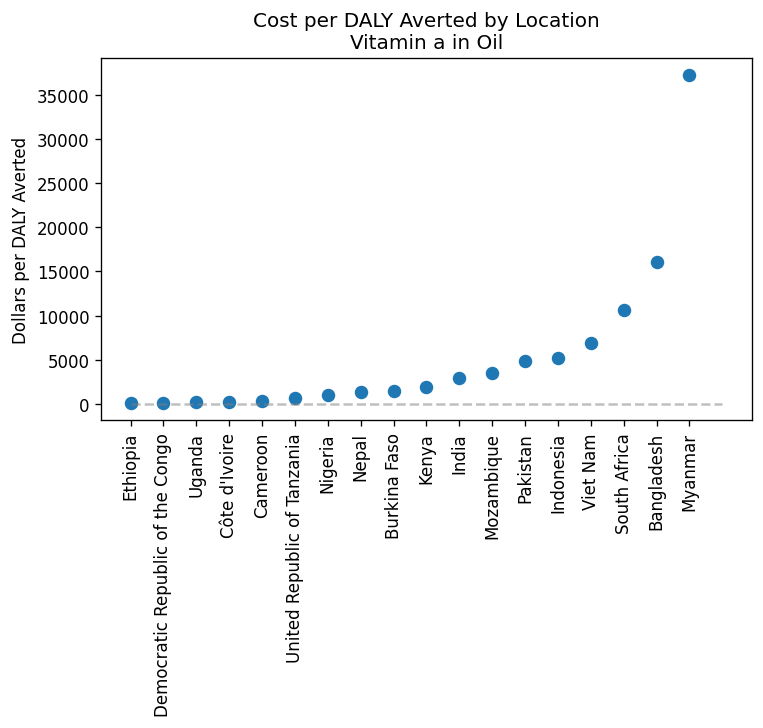

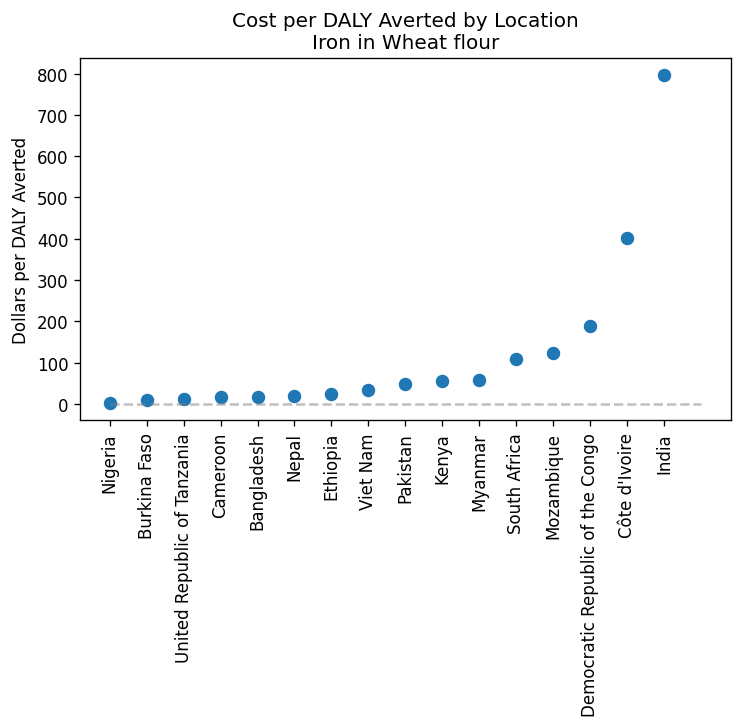

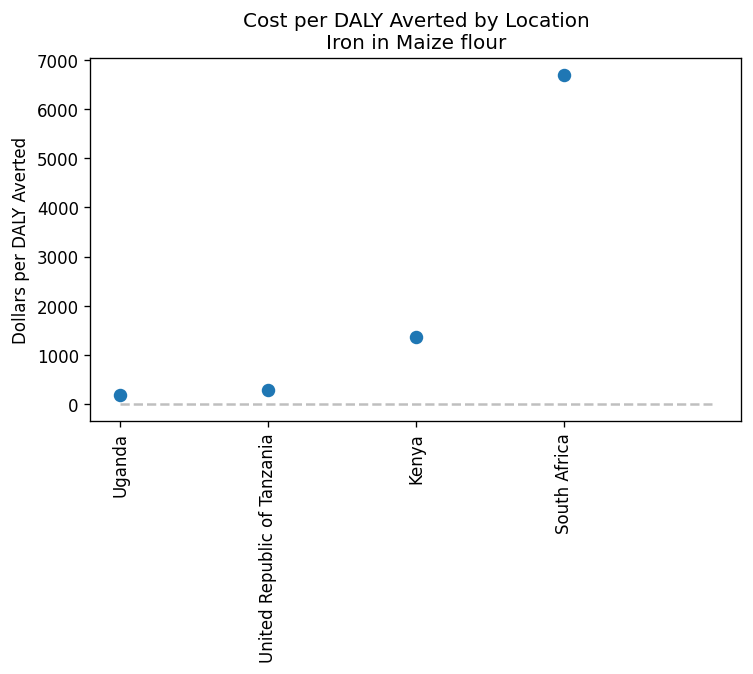

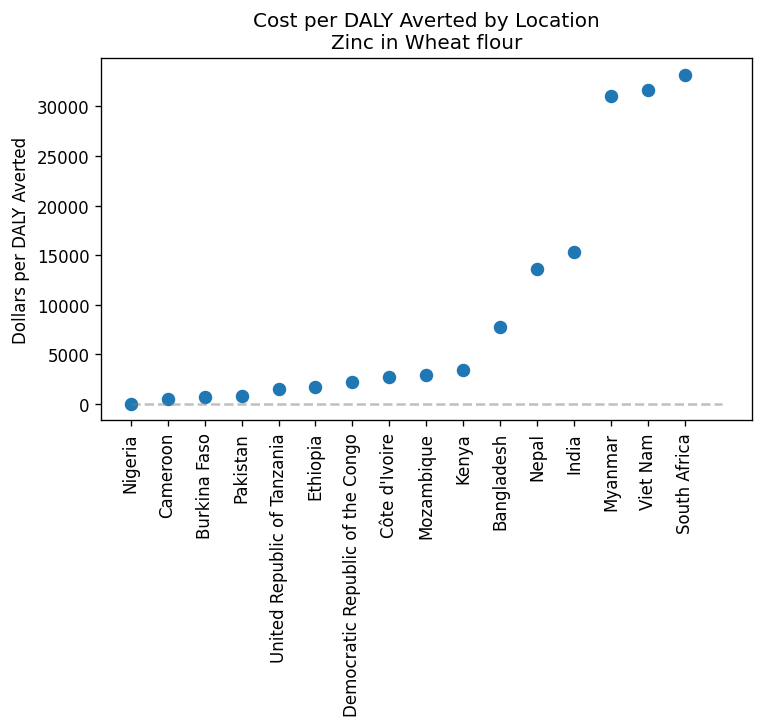

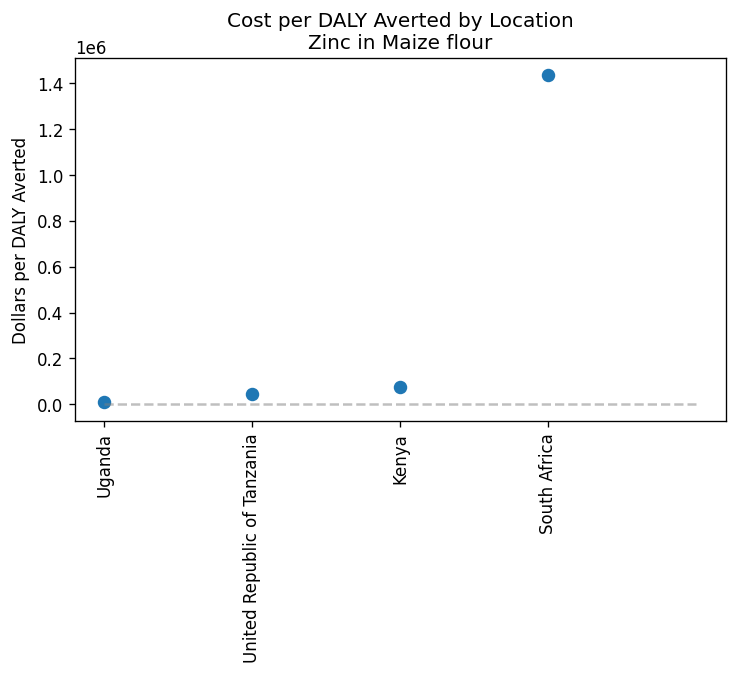

In [14]:
with PdfPages('results_plots/costs_per_daly_by_nutrient_vehicle_pair_no_caps.pdf') as pdf:

    nutrients = ['vitamin A','iron','zinc']
    for nutrient in nutrients:
        if nutrient == 'vitamin A':
            vehicles = ['oil']
            value_cap = np.inf
        else:
            vehicles = ['wheat flour','maize flour']
        if nutrient == 'iron':
            value_cap = np.inf
        if nutrient == 'zinc':
            value_cap == np.inf
        for vehicle in vehicles:
            make_cost_per_daly_plots(results_icers, vehicle, nutrient, value_cap, False)
            pdf.savefig(bbox_inches='tight')
            #make_cost_per_daly_plots(results_icers, vehicle, nutrient, value_cap, True)
            #pdf.savefig(bbox_inches='tight')

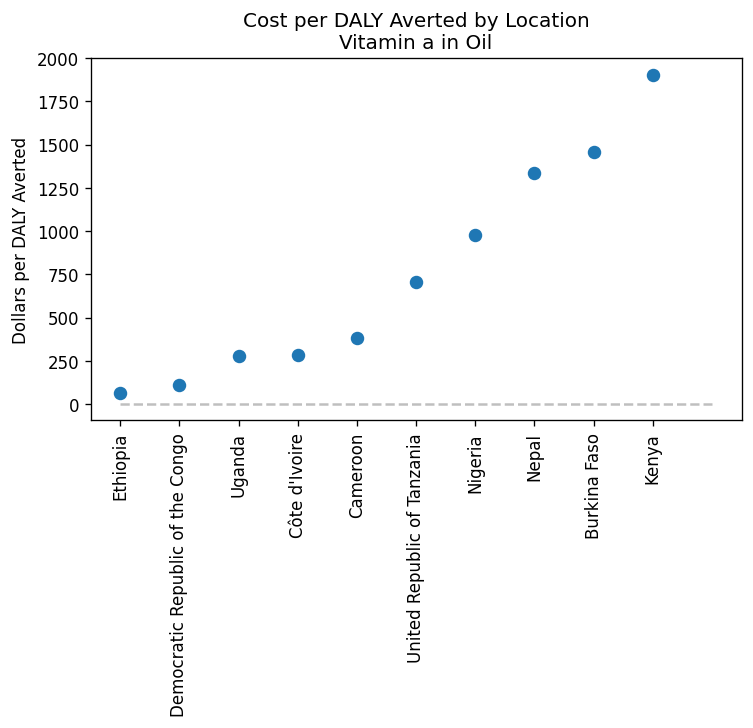

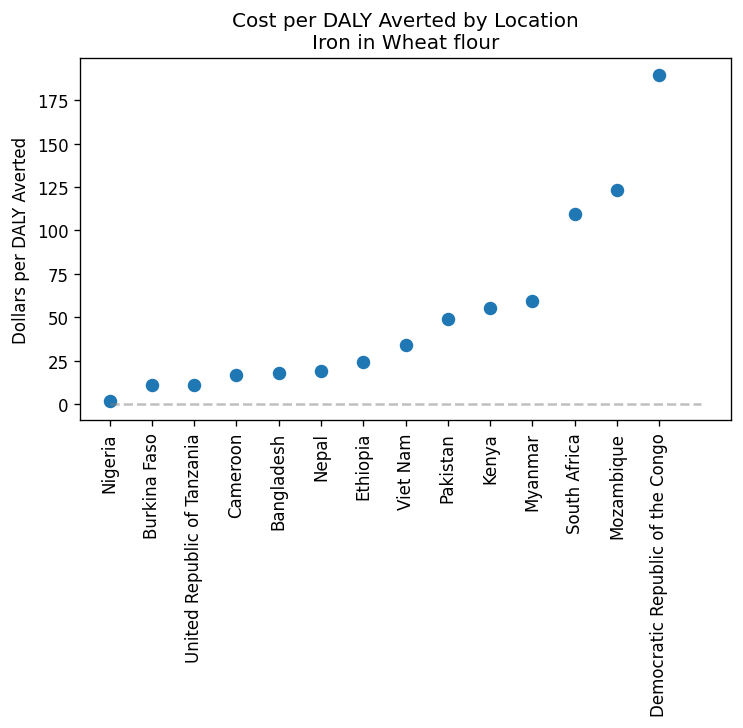

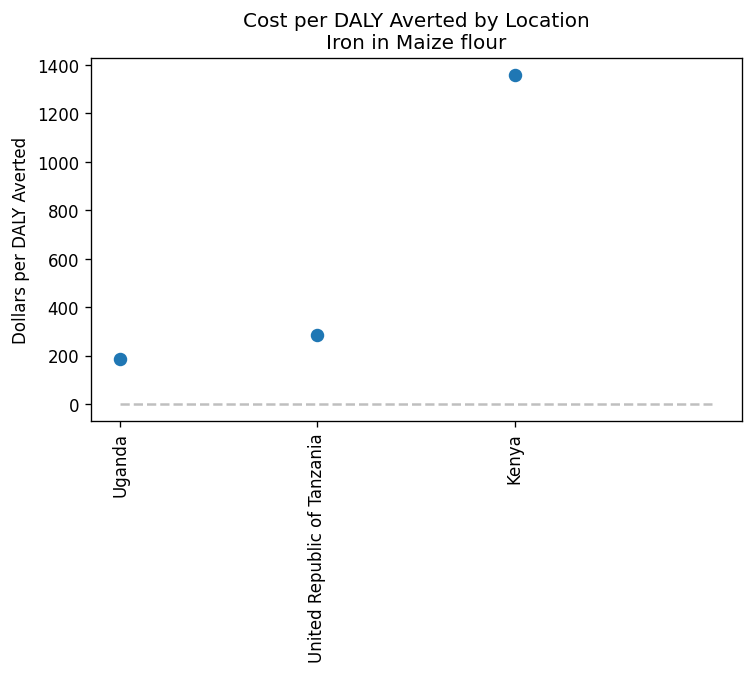

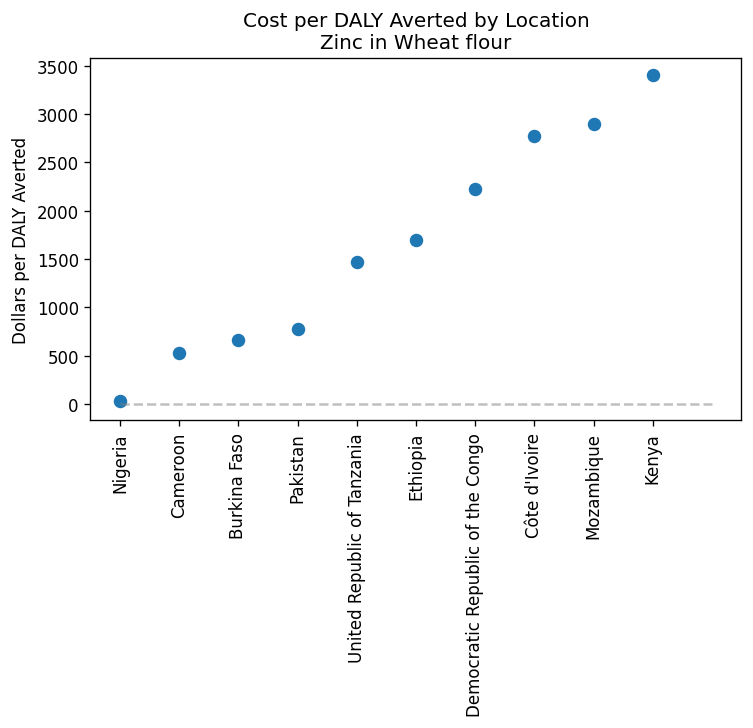

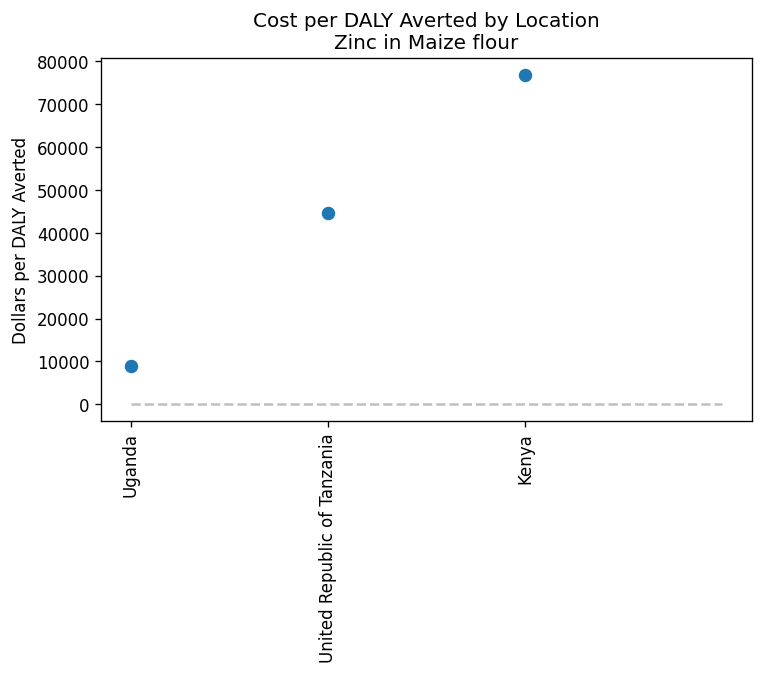

In [19]:
with PdfPages('results_plots/costs_per_daly_by_nutrient_vehicle_pair_with_caps.pdf') as pdf:

    nutrients = ['vitamin A','iron','zinc']
    for nutrient in nutrients:
        if nutrient == 'vitamin A':
            vehicles = ['oil']
            value_cap = 2_000
        else:
            vehicles = ['wheat flour','maize flour']
        for vehicle in vehicles:
            if nutrient == 'iron' and vehicle == 'wheat flour':
                value_cap = 200
            elif nutrient == 'iron':
                value_cap = 2_000
            elif nutrient == 'zinc' and vehicle == 'wheat flour':
                value_cap = 5_000
            elif nutrient == 'zinc':
                value_cap = 1_000_000
            make_cost_per_daly_plots(results_icers, vehicle, nutrient, value_cap, False)
            pdf.savefig(bbox_inches='tight')
            #make_cost_per_daly_plots(results_icers, vehicle, nutrient, value_cap, True)
            #pdf.savefig(bbox_inches='tight')

In [20]:
def make_location_specific_cost_per_daly_plots(data, location_id, uncertainty=True):
    df = data.loc[data.location_id == location_id]
    df['label'] = df.nutrient.str.capitalize() + ' in ' + df.vehicle
    
    f, ax = plt.subplots(figsize=(7, 4), dpi=120)
    colors = ['tab:red', 'tab:orange', 'tab:green']

    nutrient_spacer = 0.15
    x_vals = []
    for i in list(range(0, len(df))):
        if uncertainty: 
            plt.plot([nutrient_spacer * i, nutrient_spacer * i],
                     [df['2.5%'].values[i], df['97.5%'].values[i]], c='black')
            plt.scatter([nutrient_spacer * i], df['2.5%'].values[i], s=50, marker='_',
                        c='black')
            plt.scatter([nutrient_spacer * i], df['97.5%'].values[i], s=50, marker='_',
                        c='black')

        x_vals.append(nutrient_spacer * i)
    
    plt.scatter(x_vals, df['50%'], s=50)

    plt.hlines(0, 0,
               nutrient_spacer * (len(df)),
               linestyle='dashed', color='grey', alpha=0.5)
    
    plt.plot()
    
    plt.title(f'{df.location_name.unique()[0]}\nCost per DALY Averted by Nutrient and Vehicle Combination')
    plt.ylabel('Dollars per DALY Averted')

    x_ticks = []
    for x in list(range(0, len(df))):
        x_ticks.append(nutrient_spacer * x)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(df.label.values)
    plt.xticks(rotation=90)

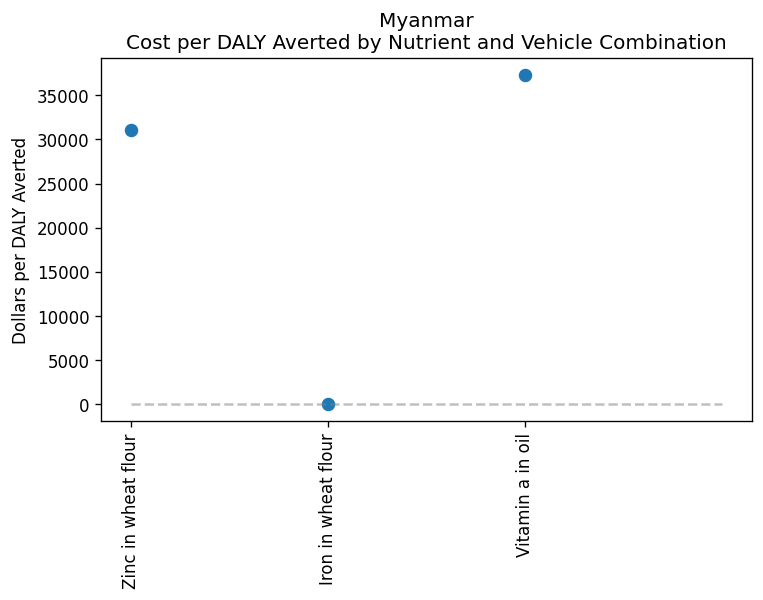

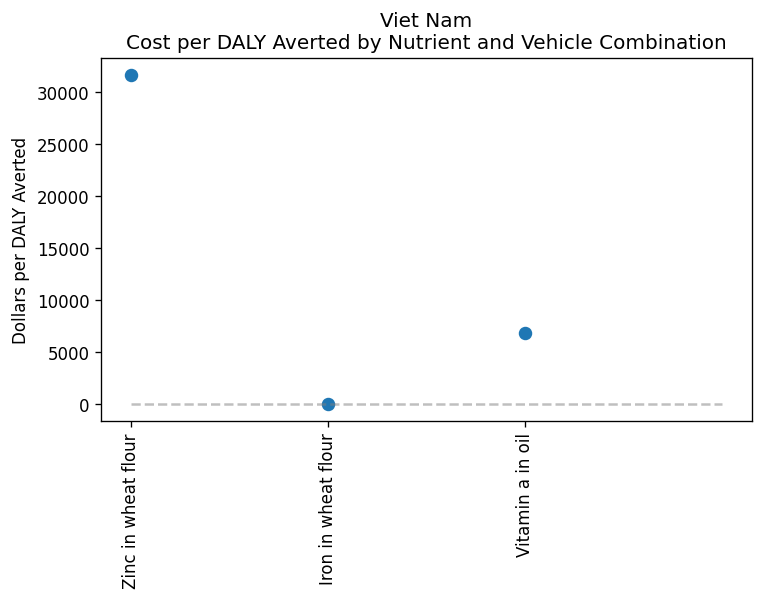

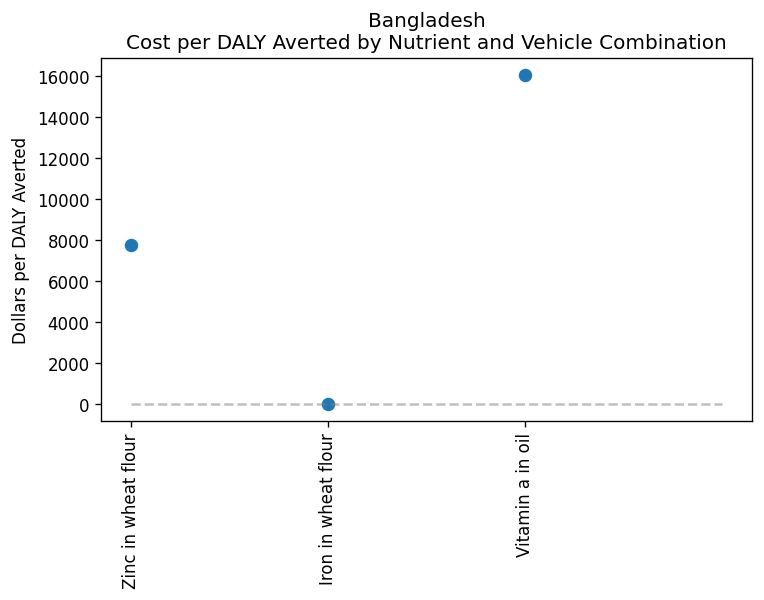

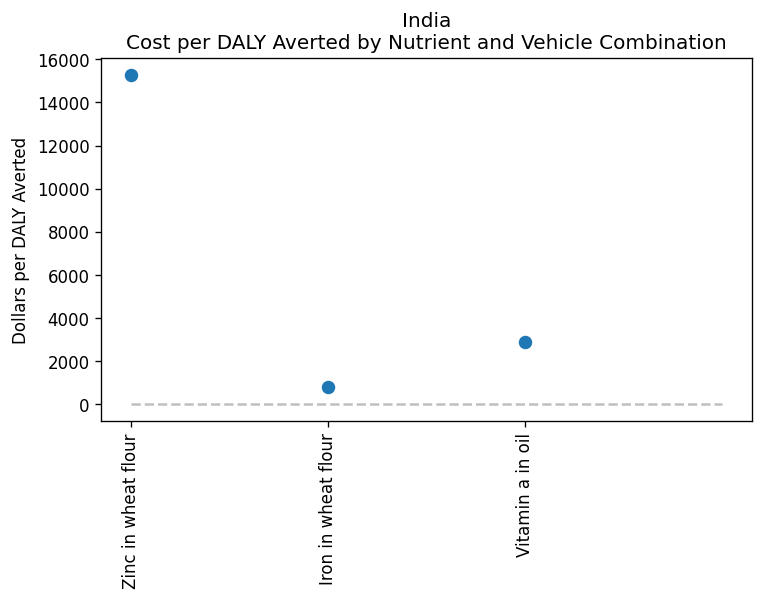

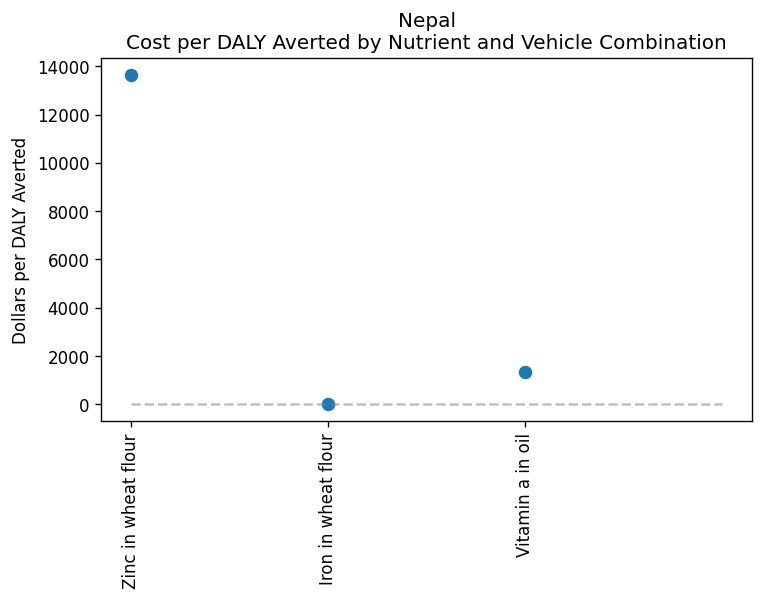

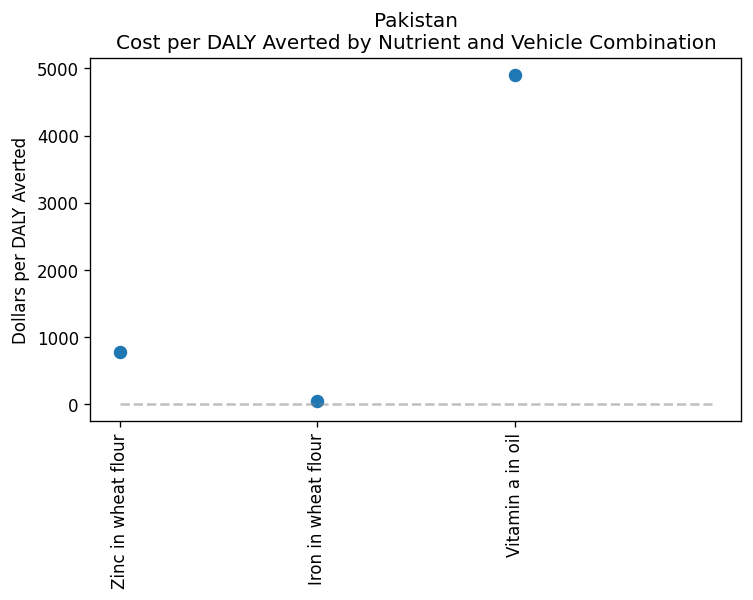

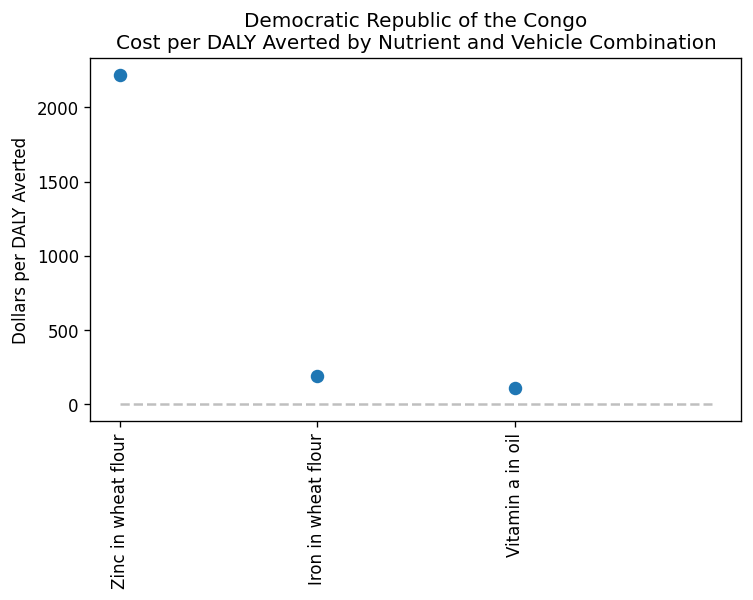

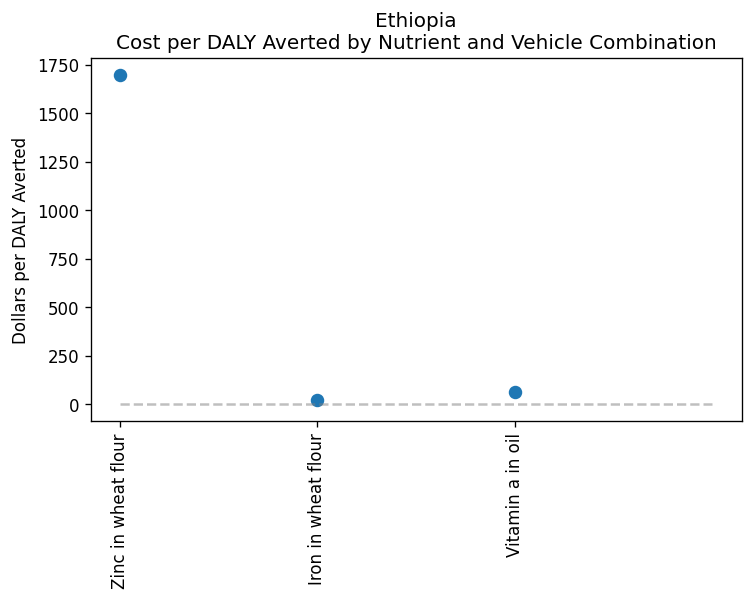

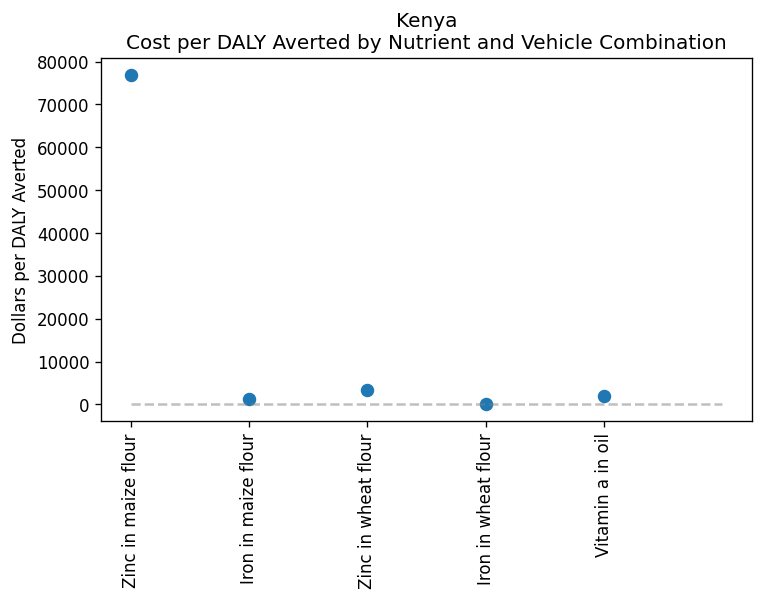

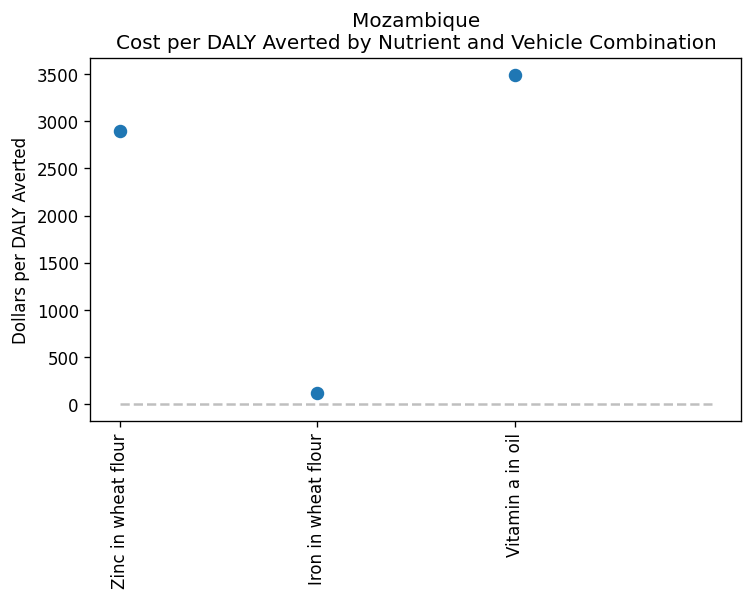

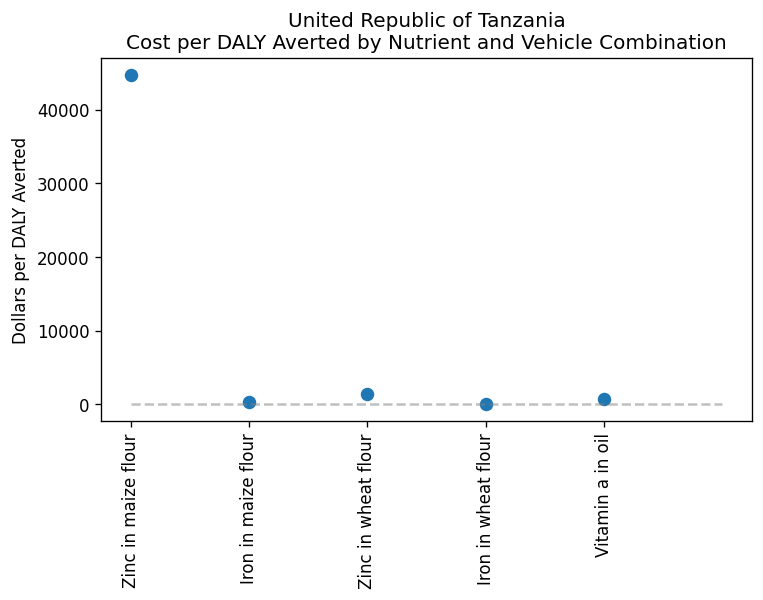

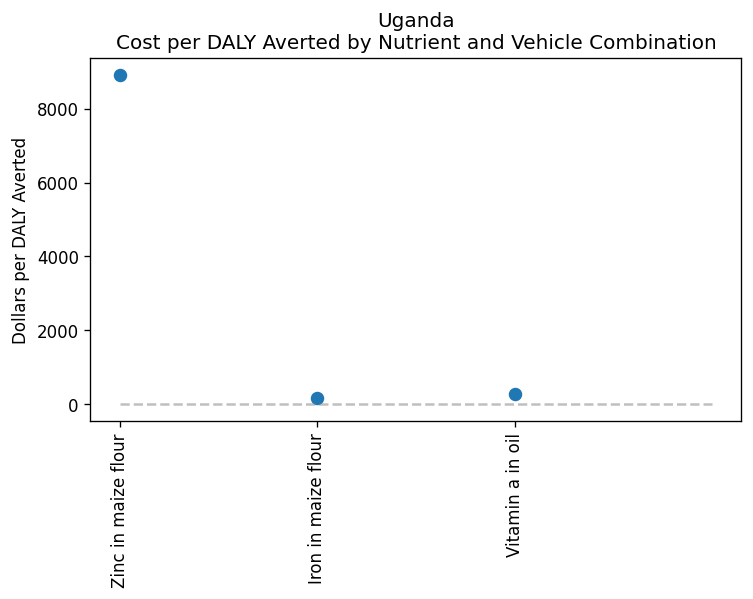

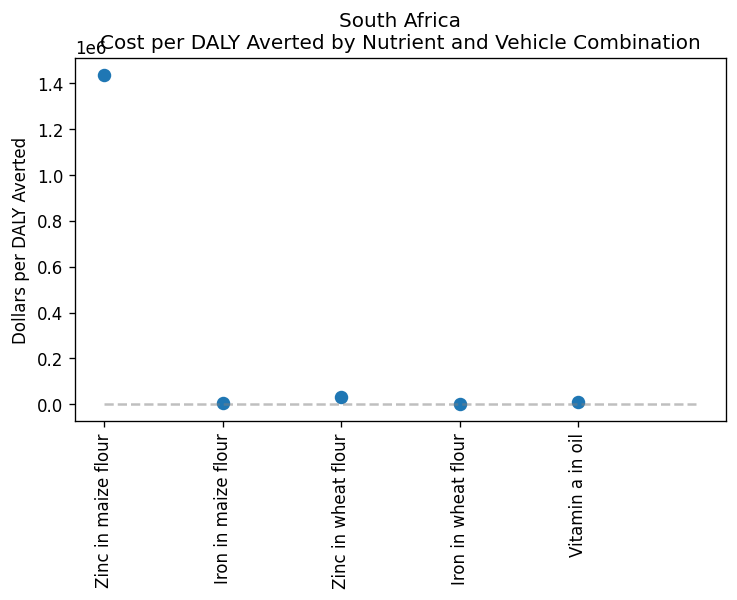

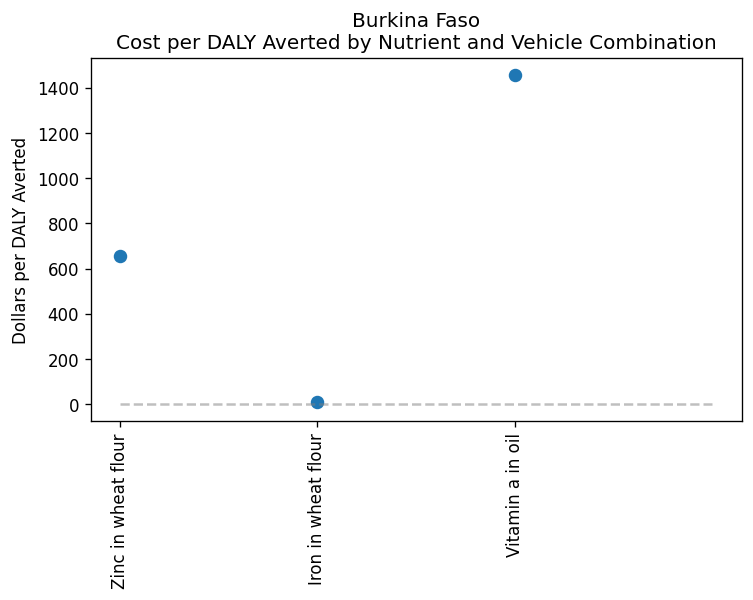

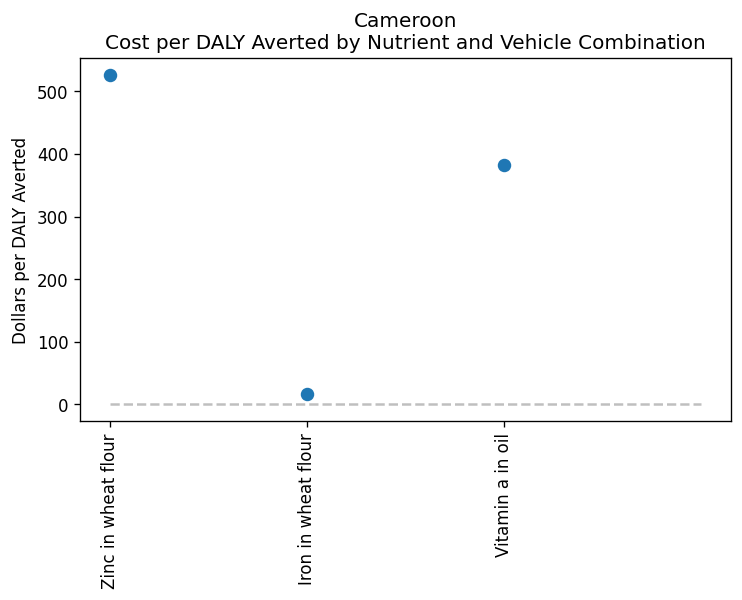

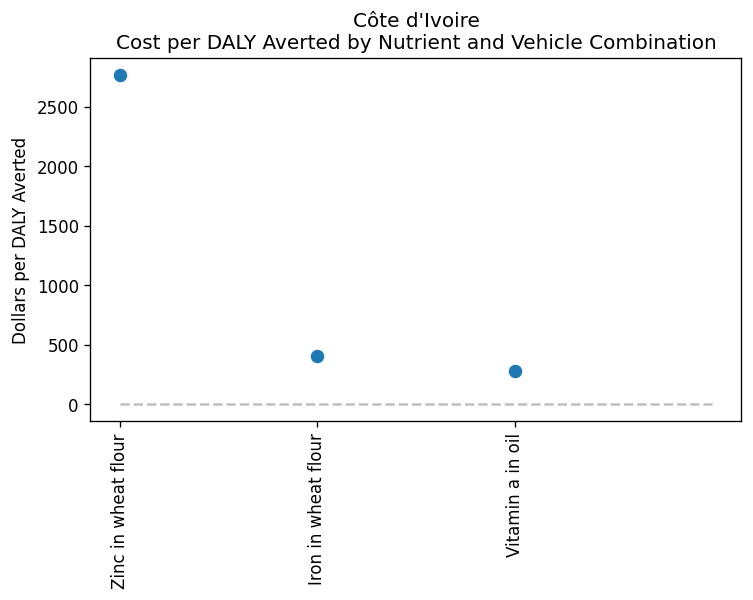

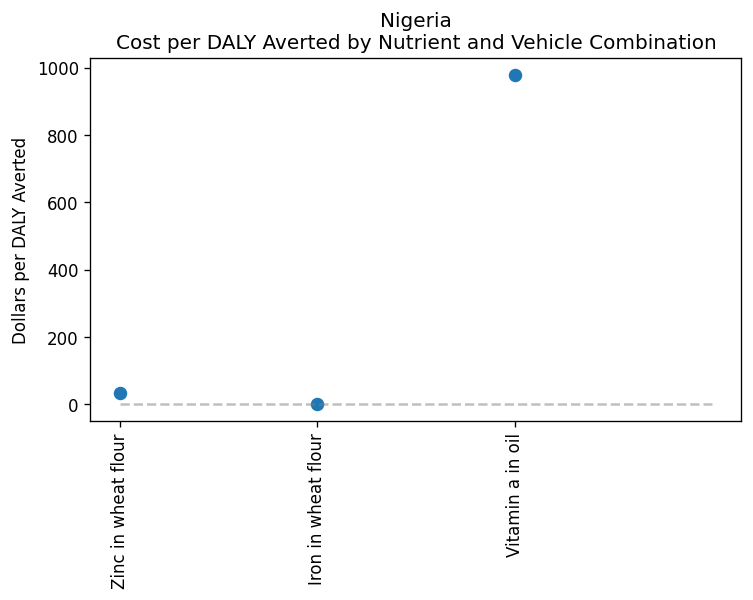

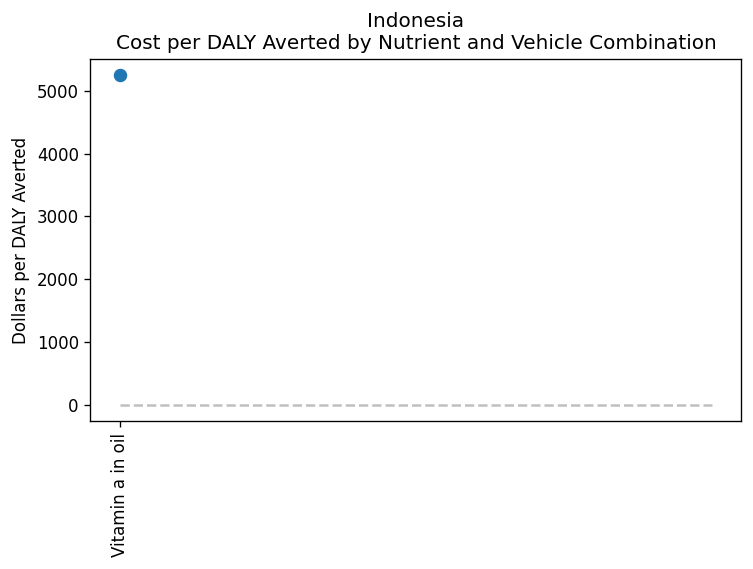

In [21]:
for location_id in results_icers.location_id.unique():
    #make_location_specific_cost_per_daly_plots(results_icers, location_id, uncertainty=True)
    make_location_specific_cost_per_daly_plots(results_icers, location_id, uncertainty=False)